In [125]:
import numpy as np, pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt, seaborn as sns
import scipy
import warnings
import plotly.express as px
from itertools import product
import statsmodels.api as sm
import datetime
from tqdm import tqdm
import io
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import resample
import statistics
from wordcloud import WordCloud
from numpy import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [130]:
# use this code if using google colab, otherwise comment it out
#from google.colab import files
#uploaded = files.upload()

## PART 1 Data Cleaning

In [129]:
# read in our dataset
df = pd.read_csv('Covid19-vaccination.csv')
df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003


In [20]:
df.shape

(63006, 16)

In [21]:
# we have a lot of missing values
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                     27277
people_vaccinated                      28883
people_fully_vaccinated                31853
total_boosters                         56393
daily_vaccinations_raw                 33083
daily_vaccinations                       326
total_vaccinations_per_hundred         27277
people_vaccinated_per_hundred          28883
people_fully_vaccinated_per_hundred    31853
total_boosters_per_hundred             56393
daily_vaccinations_per_million           326
daily_people_vaccinated                 1558
daily_people_vaccinated_per_hundred     1558
dtype: int64

In [22]:
#drop total_vaccinations missing data, as without this value any raw doesn't make much sense.
#we can see that the NAN values dropped significantly 
df = df.drop(df[df.total_vaccinations.isna()].index)
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                       1879
people_fully_vaccinated                 4751
total_boosters                         29169
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

In [23]:
# reset the index for new df
df.index  = np.arange(0,len(df))

In [24]:
df[340:355]

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
340,Albania,ALB,2021-01-15,308.0,308.0,NaN,NaN,42.0,62.0,0.01,0.01,NaN,NaN,22.0,62.0,0.002
341,Albania,ALB,2021-01-16,369.0,369.0,NaN,NaN,61.0,62.0,0.01,0.01,NaN,NaN,22.0,62.0,0.002
342,Albania,ALB,2021-01-17,405.0,405.0,NaN,NaN,36.0,58.0,0.01,0.01,NaN,NaN,20.0,58.0,0.002
343,Albania,ALB,2021-01-18,447.0,447.0,NaN,NaN,42.0,55.0,0.02,0.02,NaN,NaN,19.0,55.0,0.002
344,Albania,ALB,2021-01-19,483.0,483.0,NaN,NaN,36.0,51.0,0.02,0.02,NaN,NaN,18.0,51.0,0.002
345,Albania,ALB,2021-01-20,519.0,519.0,NaN,NaN,36.0,47.0,0.02,0.02,NaN,NaN,16.0,47.0,0.002
346,Albania,ALB,2021-01-21,549.0,549.0,NaN,NaN,30.0,40.0,0.02,0.02,NaN,NaN,14.0,40.0,0.001
347,Albania,ALB,2021-02-02,550.0,549.0,1.0,NaN,NaN,0.0,0.02,0.02,0.00,NaN,0.0,0.0,0.000
348,Albania,ALB,2021-02-09,1127.0,689.0,438.0,NaN,NaN,82.0,0.04,0.02,0.02,NaN,29.0,20.0,0.001
349,Albania,ALB,2021-02-17,1701.0,1090.0,611.0,NaN,NaN,72.0,0.06,0.04,0.02,NaN,25.0,50.0,0.002


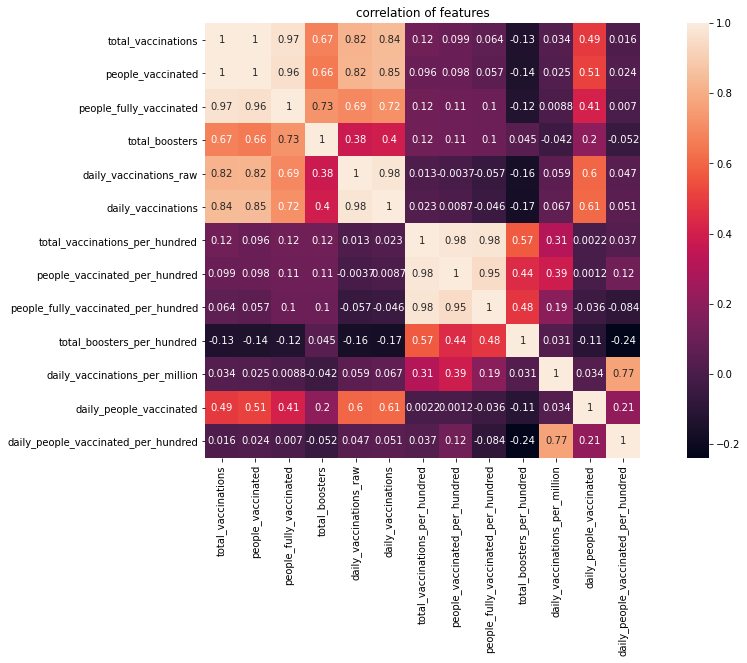

In [25]:
# correlation matrix of features
plt.subplots(figsize=(17, 8))
sns.heatmap(df.corr(), annot=True, square=True)
plt.title("correlation of features")
plt.show()

we can see from the above correlation plot and df that 'total_vaccinations' is highly correlated(almost the same) to 'people_vaccinated' and 'people_fully_vaccinated'. And is approximately the sum of  'people_fully_vaccinated', 'people_vaccinated' and total_boosters. 

we also noticed that 'total_vaccinations_per_hundred' is higly correlated to 'people_vaccinated_per_hundred' and  'people_fully_vaccinated_per_hundred'.
'total_vaccinations_per_hundred' is approximately the sum of 'people_vaccinated_per_hundred' , 'people_fully_vaccinated_per_hundred' and 'total_boosters_per_hundred'.	

'daily_vaccinations_raw' has a high correlation with 'daily_vaccinations'

We will use the Mann-Whitney U rank test to see if any pair of features has the same distribution which can be used to approximate the values for each other.

The null hypothesis is that the 2 sample distributions are the same(each pair we calculated in the next heatmap)

In [26]:
# we do not need the non-numeric features(eg.location,iso_code, date) for the test
list(df.columns)[3:]

['total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'daily_vaccinations_raw',
 'daily_vaccinations',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'people_fully_vaccinated_per_hundred',
 'total_boosters_per_hundred',
 'daily_vaccinations_per_million',
 'daily_people_vaccinated',
 'daily_people_vaccinated_per_hundred']

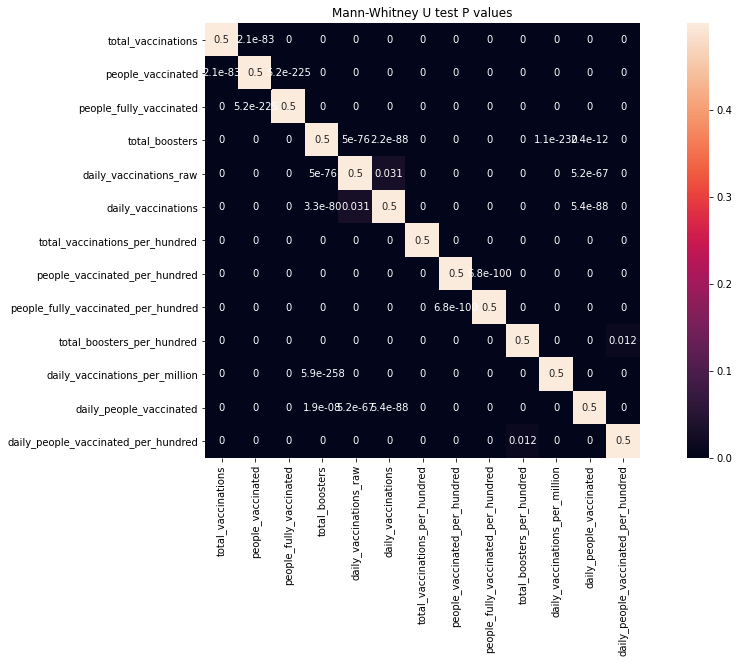

In [27]:
# the procedure for getting p-values for Mann-Whitney U rank test of each feature pair
test_result = []# this is a 2 dimentional list
# i and j are features
for i in list(df.columns)[3:]:
    #Need to use df to initialize a new check_df for every new i
    # remove NANs of column i for fair comparison with j. 
    check_df = df.drop(df[df[i].isna()].index)
    check_df.index  = np.arange(0,len(check_df))# need to reindex
    temp = [] # row list 
    for j in list(df.columns)[3:]:
        # remove NANs of column j for fair comparison with i
        check_df = check_df.drop(check_df[check_df[j].isna()].index)
        # need to reindex
        check_df.index  = np.arange(0,len(check_df))
        # we only want to append P-value, [0] is not needed.
        temp.append(stats.mannwhitneyu(check_df[i],check_df[j])[1])
    # each time a row of p-values is appended
    test_result.append(temp) 
plt.subplots(figsize=(17, 8))
#plot a heatmap
sns.heatmap(test_result, annot=True, square=True,yticklabels = list(check_df.columns)[3:], \
            xticklabels = list(check_df.columns)[3:])
plt.title("Mann-Whitney U test P values")
plt.show()


By looking at the heatmap, we observed that all pairs rejected the null hypothesis bacause p-value < 0.05 and we concluded that every feature pair in the heatmap has different distributions

Although we failed the strict Mann-Whitney U rank tests, But we have found some underlying relationship based on the correlation matrix and by observing the dataset. We now propose a procedure to deal with the missing values in the features.

1.if any of the'total_vaccinations', 'people_vaccinated','people_fully_vaccinated'
is missing, we calculate it using the formula: 'total_vaccinations' = 'people_vaccinated'+'people_fully_vaccinated' + 'total_boosters'

2.if any of the 'total_vaccinations_per_hundred' , 'people_vaccinated_per_hundred' ,'people_fully_vaccinated_per_hundred'is missing, we calculate it using formula: 'total_vaccinations_per_hundred' = 'people_vaccinated_per_hundred' +'people_fully_vaccinated_per_hundred'+ 'total_boosters_per_hundred

3.if one of 'daily_vaccinations_raw' and 'daily_vaccinations' is missing, we fill it with the other one.

'people_vaccinated','people_fully_vaccinated','people_vaccinated_per_hundred' are columns which numbers are increasing/cumulative for the same location(eg.Finland). So if NAN exists and we cannot approximate it using the above method due to multiple missing values(eg.'people_vaccinated' and 'people_fully_vaccinated' are missing), we can replace NAN with the last non NAN number in this location.

The same rationale for 'total_vaccinations_per_hundred' , 'people_vaccinated_per_hundred' ,'people_fully_vaccinated_per_hundred' and 'total_boosters_per_hundred'

In [28]:
df.loc[360:368,:]

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
360,Albania,ALB,2021-03-23,51690.0,NaN,NaN,NaN,3461.0,2895.0,1.80,NaN,NaN,NaN,1008.0,5575.0,0.194
361,Albania,ALB,2021-03-24,53992.0,NaN,NaN,NaN,2302.0,2946.0,1.88,NaN,NaN,NaN,1025.0,5575.0,0.194
362,Albania,ALB,2021-03-25,59348.0,NaN,NaN,NaN,5356.0,3287.0,2.07,NaN,NaN,NaN,1144.0,5575.0,0.194
363,Albania,ALB,2021-03-26,62248.0,NaN,NaN,NaN,2900.0,3276.0,2.17,NaN,NaN,NaN,1140.0,5575.0,0.194
364,Albania,ALB,2021-03-27,64075.0,NaN,NaN,NaN,1827.0,3113.0,2.23,NaN,NaN,NaN,1084.0,5575.0,0.194
365,Albania,ALB,2021-03-28,78000.0,NaN,NaN,NaN,13925.0,4678.0,2.71,NaN,NaN,NaN,1628.0,5575.0,0.194
366,Albania,ALB,2021-03-30,119321.0,NaN,NaN,NaN,NaN,9662.0,4.15,NaN,NaN,NaN,3363.0,5575.0,0.194
367,Albania,ALB,2021-03-31,138846.0,NaN,NaN,NaN,19525.0,12122.0,4.83,NaN,NaN,NaN,4219.0,5575.0,0.194
368,Albania,ALB,2021-04-01,155463.0,NaN,NaN,NaN,16617.0,13731.0,5.41,NaN,NaN,NaN,4779.0,5575.0,0.194


In [29]:

for i in range(0,df.shape[0]):
    # if any two of 'people_vaccinated','people_fully_vaccinated' and 'total_boosters' are missing, we cannot estimate,
    # instead, we fill it with the last non-NAN value in its column because the value cannot decreasing. 
    # If it is the first data for a country, fill it with 0.
    multiple_missing1 = False# if two of 'people_vaccinated','people_fully_vaccinated' and 'total_boosters' are missing
    multiple_missing2 = False# if two of 'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred' and 'total_boosters_per_hundred' are missing
    if np.isnan(df.loc[i,'people_vaccinated']):
        df.loc[i,'people_vaccinated'] = df.loc[i,'total_vaccinations'] - \
        df.loc[i,'people_fully_vaccinated'] - df.loc[i,'total_boosters']
        # if both cell is NAN, we cannot compute the value. 
        # we choose to fill it with the last cell's value if the 'location' doesn't change
        if (np.isnan(df.loc[i,'people_fully_vaccinated']) or np.isnan(df.loc[i,'total_boosters']))\
                                        and df.loc[i,'location'] == df.loc[i-1,'location']:
            df.loc[i,'people_vaccinated'] = df.loc[i-1,'people_vaccinated']
            multiple_missing1 = True
        #if it starts a new location and the first data is missing(eg.if first data for Canada is missing, fill it with 0)
        #Short circuit evaluation, if the first condition of 'or' is true, the second doesn't matter.
        elif i == 0 or df.loc[i,'location'] != df.loc[i-1,'location']:
            df.loc[i,'people_vaccinated'] = 0
            
    if np.isnan(df.loc[i,'people_fully_vaccinated']):
        if (np.isnan(df.loc[i,'people_vaccinated']) or np.isnan(df.loc[i,'total_boosters'])):
            multiple_missing1 = True
        if not multiple_missing1:
            df.loc[i,'people_fully_vaccinated'] = df.loc[i,'total_vaccinations'] - \
            df.loc[i,'people_vaccinated']- df.loc[i,'total_boosters']           
        #if it starts a new location and the first data is missing. 
        #Short circuit evaluation, if the first condition of 'or' is true, the second doesn't matter.
        if i == 0 or df.loc[i,'location'] != df.loc[i-1,'location'] :
            df.loc[i,'people_fully_vaccinated'] = 0
        # if both cell is NAN, we cannot compute the value. 
        # we choose to fill it with the last cell's value if the 'location' doesn't change
        elif multiple_missing1 and df.loc[i,'location'] == df.loc[i-1,'location']:
            df.loc[i,'people_fully_vaccinated'] = df.loc[i-1,'people_fully_vaccinated']    


    # we apply the same process above to the per_hundred data    
    if np.isnan(df.loc[i,'people_vaccinated_per_hundred']):
        df.loc[i,'people_vaccinated_per_hundred'] = df.loc[i,'total_vaccinations_per_hundred'] - \
        df.loc[i,'people_fully_vaccinated_per_hundred'] - df.loc[i,'total_boosters_per_hundred']
        # if both cell is NAN, we cannot compute the value. 
        # we choose to fill it with the last cell's value if the 'location' doesn't change
        if (np.isnan(df.loc[i,'people_fully_vaccinated_per_hundred']) or np.isnan(df.loc[i,'total_boosters_per_hundred'])) \
                                and df.loc[i,'location'] == df.loc[i-1,'location']:
            df.loc[i,'people_vaccinated_per_hundred'] = df.loc[i-1,'people_vaccinated_per_hundred']  
            multiple_missing2 = True
        #if it starts a new location and the first data is missing   
        #Short circuit evaluation, if the first condition of 'or' is true, the second doesn't matter.
        elif i == 0 or df.loc[i,'location'] != df.loc[i-1,'location']:
            df.loc[i,'people_vaccinated_per_hundred'] = 0
            
    if np.isnan(df.loc[i,'people_fully_vaccinated_per_hundred']):
        if (np.isnan(df.loc[i,'people_vaccinated_per_hundred']) or np.isnan(df.loc[i,'total_boosters_per_hundred'])):
            multiple_missing2 = True
        if not multiple_missing2:
            df.loc[i,'people_fully_vaccinated_per_hundred'] = df.loc[i,'total_vaccinations_per_hundred'] -\
            df.loc[i,'people_vaccinated_per_hundred']- df.loc[i,'total_boosters_per_hundred']
        #if it starts a new location and the first data is missing    
        #Short circuit evaluation, if the first condition of 'or' is true, the second doesn't matter.
        if i == 0 or df.loc[i,'location'] != df.loc[i-1,'location']:
            df.loc[i,'people_fully_vaccinated_per_hundred'] = 0    
        # if both cell is NAN, we cannot compute the value. 
        # we choose to fill it with the last cell's value if the 'location' doesn't change            
        elif multiple_missing2 and df.loc[i,'location'] == df.loc[i-1,'location']:
            df.loc[i,'people_fully_vaccinated_per_hundred'] = df.loc[i-1,'people_fully_vaccinated_per_hundred']

        
    if np.isnan(df.loc[i,'daily_vaccinations_raw']):
        df.loc[i,'daily_vaccinations_raw'] = df.loc[i,'daily_vaccinations'] 
        
    elif np.isnan(df.loc[i,'daily_vaccinations']):
        df.loc[i,'daily_vaccinations'] = df.loc[i,'daily_vaccinations_raw'] 
        
    #we approximate per_million data and per_hundred data using simple math
    if np.isnan(df.loc[i,'daily_vaccinations_per_million']):
        df.loc[i,'daily_vaccinations_per_million'] = df.loc[i,'daily_people_vaccinated_per_hundred'] *\
        10000
        
    elif np.isnan(df.loc[i,'daily_people_vaccinated_per_hundred']):
        df.loc[i,'daily_people_vaccinated_per_hundred'] = df.loc[i,'daily_vaccinations_per_million'] /\
        10000
      

In [30]:
# we can see that we only have a few NANs left in contrast to the large amount of NANs at the beginning
# we fill the rest of the NAN values with 0 which cannot be derived from their correlated features
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                          0
people_fully_vaccinated                    0
total_boosters                         29169
daily_vaccinations_raw                   235
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred              0
people_fully_vaccinated_per_hundred        0
total_boosters_per_hundred             29169
daily_vaccinations_per_million           233
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      233
dtype: int64

In [31]:
# we did our best to approximate the NANs and the we have to fill the rest of the missing values with 0s 
# since their pair-wise distributions are not the same.
df.total_boosters = df.total_boosters.fillna(0)
df.total_boosters_per_hundred = df.total_boosters_per_hundred.fillna(0)
df.daily_vaccinations_raw = df.daily_vaccinations_raw.fillna(0)
df.daily_vaccinations = df.daily_vaccinations.fillna(0)
df.daily_vaccinations_per_million = df.daily_vaccinations_per_million.fillna(0)
df.daily_people_vaccinated = df.daily_people_vaccinated.fillna(0)
df.daily_people_vaccinated_per_hundred = df.daily_people_vaccinated_per_hundred.fillna(0)
df.isna().sum()

location                               0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
total_boosters                         0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
total_boosters_per_hundred             0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
dtype: int64

In [32]:
df

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.000
1,Afghanistan,AFG,2021-02-28,8200.0,8200.0,0.0,0.0,1367.0,1367.0,0.02,0.02,0.00,0.0,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-03-16,54000.0,54000.0,0.0,0.0,2862.0,2862.0,0.14,0.14,0.00,0.0,72.0,2862.0,0.007
3,Afghanistan,AFG,2021-04-07,120000.0,120000.0,0.0,0.0,3000.0,3000.0,0.30,0.30,0.00,0.0,75.0,3000.0,0.008
4,Afghanistan,AFG,2021-04-22,240000.0,240000.0,0.0,0.0,8000.0,8000.0,0.60,0.60,0.00,0.0,201.0,8000.0,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35724,Zimbabwe,ZWE,2021-11-16,6228119.0,3515140.0,2712979.0,0.0,37816.0,24487.0,41.27,23.29,17.98,0.0,1622.0,17188.0,0.114
35725,Zimbabwe,ZWE,2021-11-18,6310431.0,3583256.0,2727175.0,0.0,29822.0,29822.0,41.81,23.74,18.07,0.0,1976.0,22810.0,0.151
35726,Zimbabwe,ZWE,2021-11-19,6362499.0,3625221.0,2737278.0,0.0,52068.0,33163.0,42.16,24.02,18.14,0.0,2197.0,25915.0,0.172
35727,Zimbabwe,ZWE,2021-11-20,6396012.0,3651820.0,2744192.0,0.0,33513.0,34377.0,42.38,24.20,18.18,0.0,2278.0,26983.0,0.179


## PART 2 Data Visualization and Exploratory Data Analysis

In [33]:
df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000
1,Afghanistan,AFG,2021-02-28,8200.0,8200.0,0.0,0.0,1367.0,1367.0,0.02,0.02,0.0,0.0,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-03-16,54000.0,54000.0,0.0,0.0,2862.0,2862.0,0.14,0.14,0.0,0.0,72.0,2862.0,0.007
3,Afghanistan,AFG,2021-04-07,120000.0,120000.0,0.0,0.0,3000.0,3000.0,0.30,0.30,0.0,0.0,75.0,3000.0,0.008
4,Afghanistan,AFG,2021-04-22,240000.0,240000.0,0.0,0.0,8000.0,8000.0,0.60,0.60,0.0,0.0,201.0,8000.0,0.020


#1.which countries has the most fully vaccinated people?

In [34]:
# we are interested in the countries not the continents or other groups, 
# so we do not include continent data and other group data in our analysis
noncountries = ['World', 'Upper middle income','Lower middle income', 'High income', \
                'Lower middle income','Low income', 'Asia', 'South America','Africa' , \
                'Europe','North America','European Union','Oceania','South Africa']
              
locations = set(df[~df['location'].isin(noncountries)].location)

In [35]:
len(locations)

222

In [36]:
len(df['location'].unique())

235

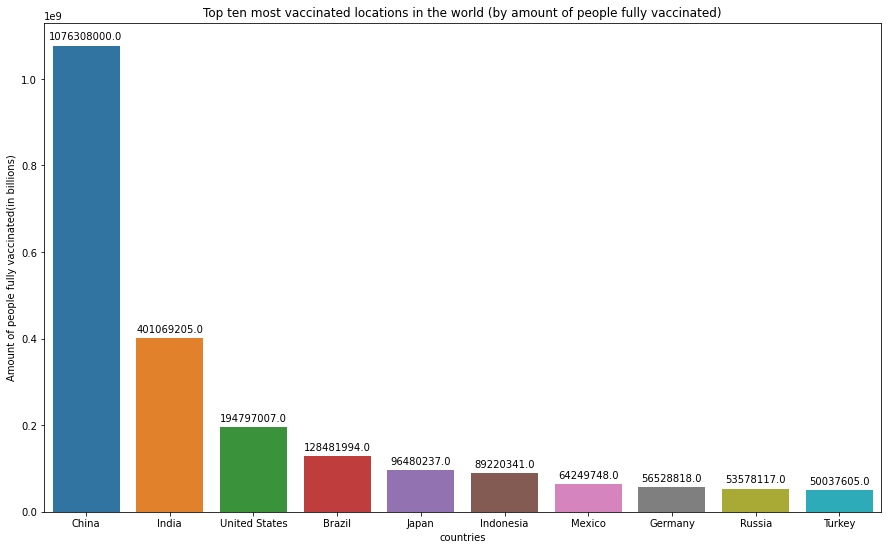

In [37]:
# Group the data by locations and perform a descending sort
top_fully_vaccinated = df[df['location'].isin(locations)].groupby('location') \
.people_fully_vaccinated.max() .sort_values(ascending=False).dropna(axis=0).reset_index() 

#display(top_fully_vaccinated[0:10])

plt.figure(figsize=(15, 9))
plt.title('Top ten most vaccinated locations in the world (by amount of people fully vaccinated)')
splot = sns.barplot(x=top_fully_vaccinated['location'][0:10], y=top_fully_vaccinated['people_fully_vaccinated'][0:10])
plt.xlabel('countries')
plt.ylabel('Amount of people fully vaccinated(in billions)')

#annotate the amount above each bin
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

The associated wordcloud reflects the number of people fully vaccinated on the size of the text/country name. The bigger the size, the larger the number. 


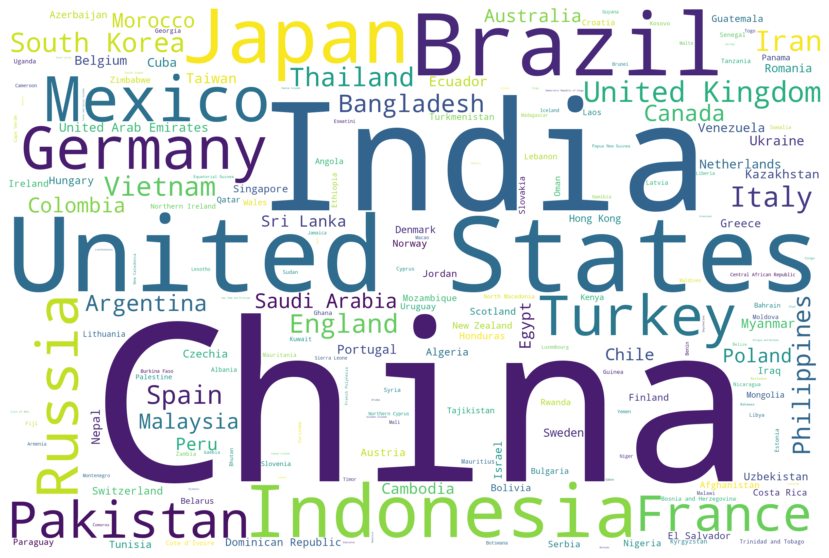

In [38]:
# display a wordcloud based on the number of people fully vaccinated in the location
d = {}
for a, x in top_fully_vaccinated.values:
    d[a] = x

wordcloud = WordCloud(background_color = "white",width = 2400, height = 1600)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

But many of the top countries are also the most populous, we have to take into account the fully vaccinated rate.
In this case, the fully vaccinated rate(per hundred) matters when analyzing vaccination trends and the possible new variants emerged.



#2.which countries has the most fully vaccination rate?

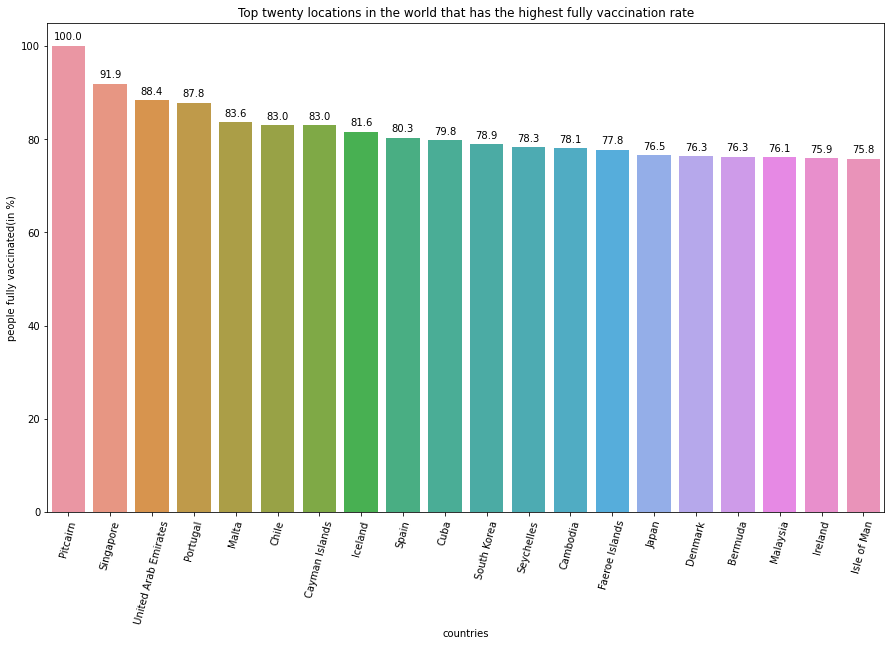

In [39]:
# Group the data by locations and perform a descending sort
top_vaccinated_rate = df[df['location'].isin(locations)].groupby('location') \
.people_fully_vaccinated_per_hundred.max().sort_values(ascending=False).dropna(axis=0).reset_index() 

#display(top_vaccinated_rate[0:10])

plt.figure(figsize=(15, 9))
plt.title('Top twenty locations in the world that has the highest fully vaccination rate')
# we have to exclude Gibraltar because its rate is over 100%. It is not meaningful.
splot = sns.barplot(x=top_vaccinated_rate['location'][1:21], y=top_vaccinated_rate['people_fully_vaccinated_per_hundred'][1:21])
plt.xlabel('countries')
plt.xticks(rotation=75)
plt.ylabel('people fully vaccinated(in %)')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

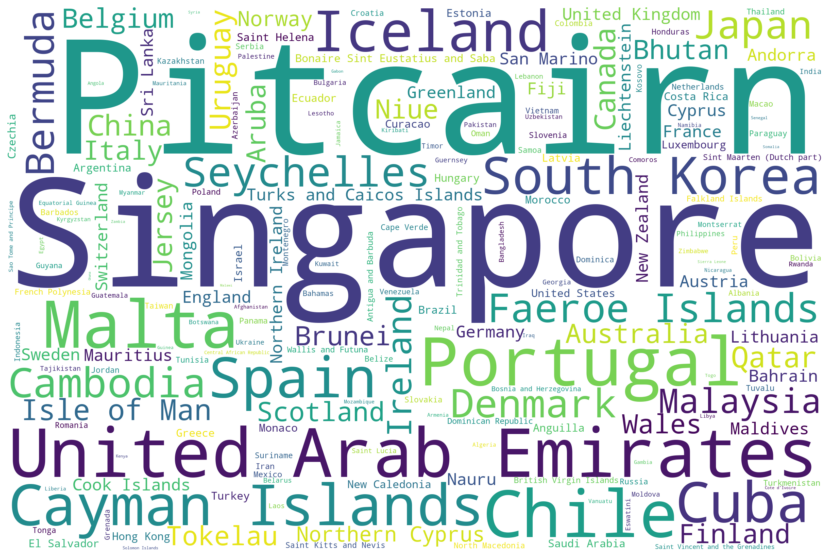

In [40]:
# the associated wordcloud based on the fully vaccinated rate
d = {}
for a, x in top_vaccinated_rate.values[1:]:
    d[a] = x

wordcloud = WordCloud(background_color = "white",width = 2400, height = 1600)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

we can see that pitcairn has a 100% vaccination rate but it is not very surprising since its population is very small. Among  the top ten fully vaccinated countries in part1, only Japan is in the top 20 countries that have the highest fully vaccination rate in the world.

#3.which countries are the most active in participating in getting covid vaccination?

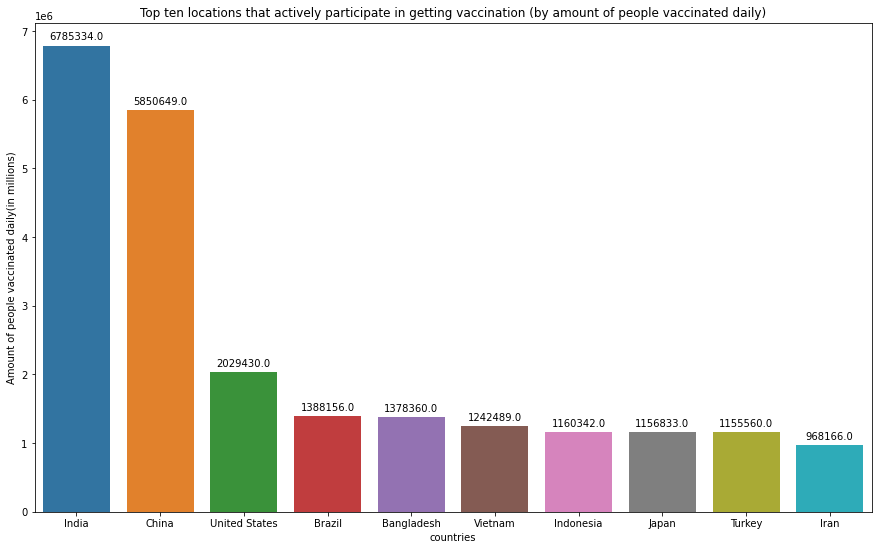

In [41]:
# Group the data by locations and perform a descending sort
top_people_vaccinated = df[df['location'].isin(locations)].groupby('location') \
.daily_people_vaccinated.max() .sort_values(ascending=False).dropna(axis=0).reset_index() 

#display(top_people_vaccinated[0:10])

# Plotting a barplot for data viz using matplotlib and seaborn
plt.figure(figsize=(15, 9))
plt.title('Top ten locations that actively participate in getting vaccination (by amount of people vaccinated daily)')
splot = sns.barplot(x=top_people_vaccinated['location'][0:10], y=top_people_vaccinated['daily_people_vaccinated'])
plt.xlabel('countries')
plt.ylabel('Amount of people vaccinated daily(in millions)');

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

The associated wordcloud reflects the number of people fully vaccinated on the size of the text/country name. The bigger the size, the larger the number. 


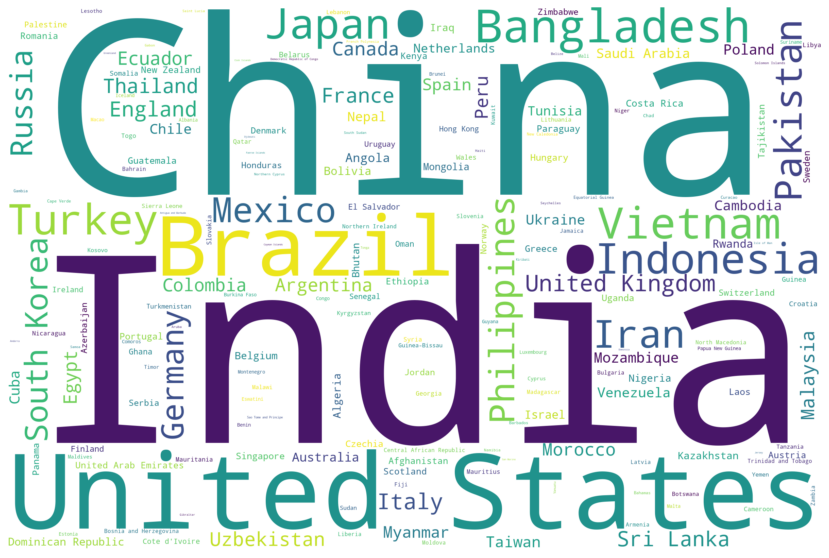

In [42]:
# the associated wordcloud based on how active people in a location participate in getting vaccinated
d = {}
for a, x in top_people_vaccinated.values:
    d[a] = x

wordcloud = WordCloud(background_color = "white",width = 2400, height = 1600)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


We can also see a pattern here. Most of the top countries can produce vaccines themselves such as the US and China. The countries with larger vaccine supply, bigger populations and more resources seems to have people that are more active in getting vaccinations. So, the amount of people getting vaccinated daily does have something to do with the amount of daily produced vaccines as well.



#4 what is the progression of the people vaccinated daily over time?

In [43]:
top_people_vaccinated.head()

,location,daily_people_vaccinated
0,India,6785334.0
1,China,5850649.0
2,United States,2029430.0
3,Brazil,1388156.0
4,Bangladesh,1378360.0


In [44]:
# we get the top 10 fully vaccinated countries
top_people_vaccinated_countries = list(top_people_vaccinated.loc[0:9,'location'].values)
top_people_vaccinated_countries

['India',
 'China',
 'United States',
 'Brazil',
 'Bangladesh',
 'Vietnam',
 'Indonesia',
 'Japan',
 'Turkey',
 'Iran']

In [45]:
# we only need the the data for the ten countries 
temp = df[['location', 'date', 'daily_people_vaccinated']].sort_values(by='daily_people_vaccinated', ascending=True)
temp = temp[temp['location'].isin(top_people_vaccinated_countries)].dropna()
temp

,location,date,daily_people_vaccinated
15989,Japan,2021-02-17,0.0
14652,Iran,2021-02-08,0.0
14083,India,2021-01-15,0.0
14383,Indonesia,2021-01-12,0.0
5956,China,2021-02-09,0.0
...,...,...,...
14324,India,2021-09-24,5888195.0
14313,India,2021-09-13,6026337.0
14303,India,2021-09-03,6229826.0
14301,India,2021-09-01,6618112.0


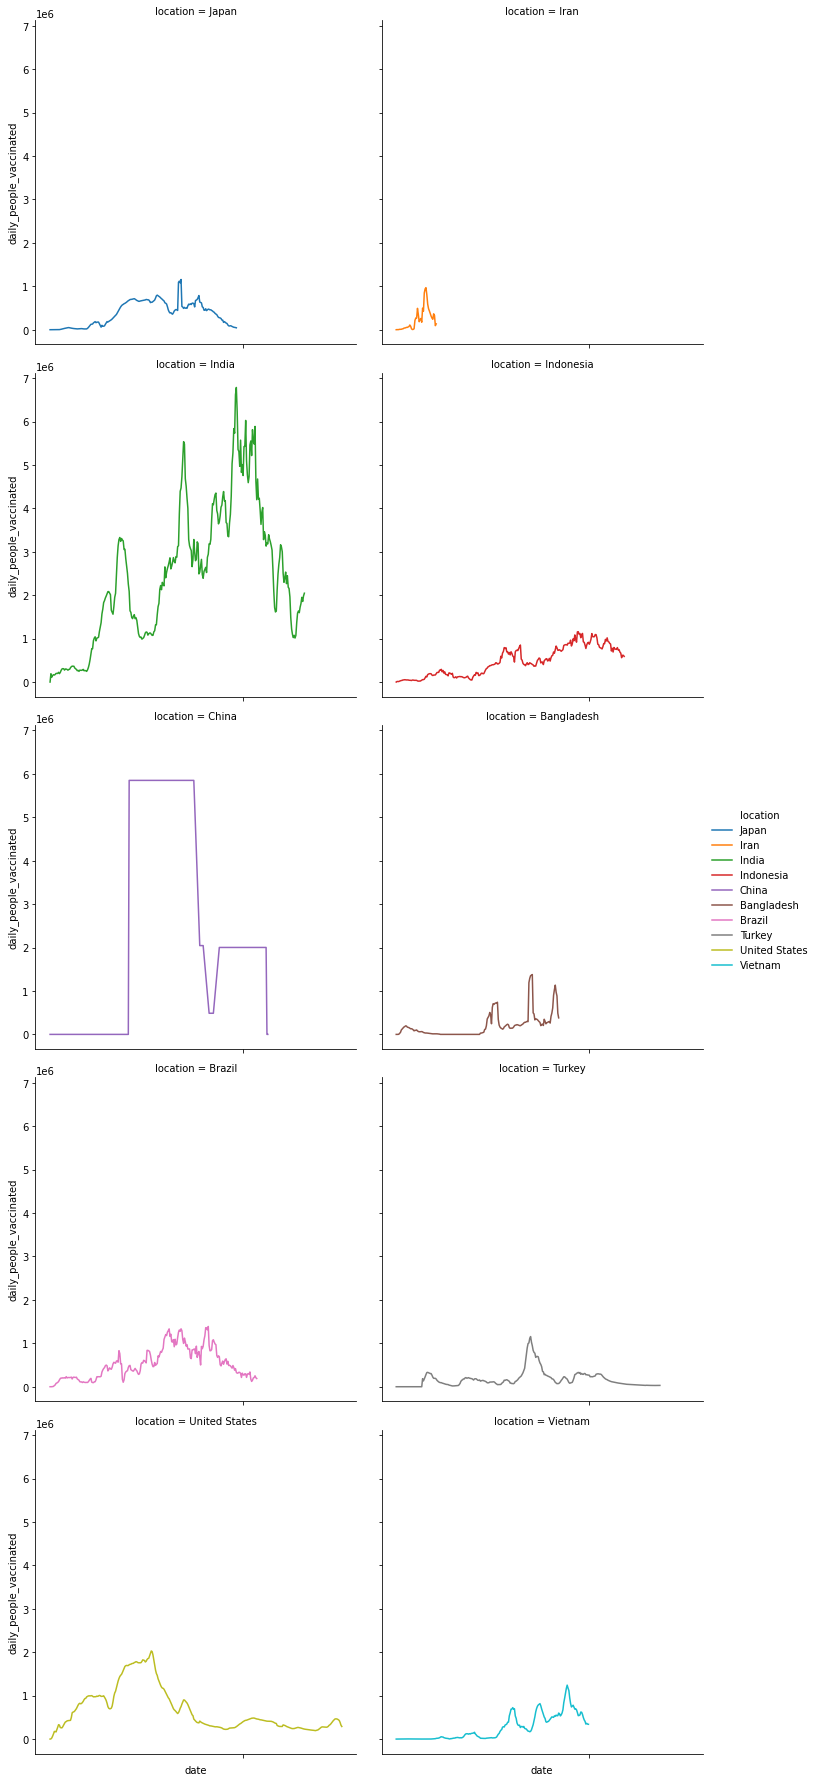

In [46]:
sns.relplot(data=temp, x='date', y='daily_people_vaccinated', hue='location', col='location', kind='line', col_wrap=2)
plt.xticks('');

We can see that each country's curve follows a similar basic pattern, which is more or less like a normal distribution. The peak is somewhere in the middle of the curve. China and India has large amount of people vaccinated daily compared to other countries. One reason maybe that they have the world's most dense population, but we can also interpret this as their people are more serious about the pandemic or more active in fighting against the pandemic. The 'hill' like or 'Guassian distribution' like shape indicates that at the beginning, people were panic about the pandemic, so more and more people were eager to get the vaccination to avoid getting infected. But as more and more people got vaccinated, and more and more regulations are imposed , the pandemic situation got better and better. And people start to be less worried about the impact of the pandemic so they may postpone the date to get vaccinated and some even give up the plan to get vaccinated.

We can also see that Vietnam, Bangladesh, Japan and Iran end their line ealier than other countries. The reasons might be: 1. missing data. 2. They simply did not vaccinate people due to some circumstances. 3. Some transportation blocks imposed by some countries. 4. They are not able to produce vaccines themselves and rely on other countries who produce vaccines domestically. As an example, China and United States continues to vaccinate people over the periods in the dataset. 

## PART3 Model selection and fitting to data

Monte Carlo simulation modelling

A Monte Carlo simulation is a model used to predict the probability of different outcomes when the intervention of random variables is present.

The basis of a Monte Carlo simulation is that the probability of varying outcomes cannot be determined because of random variable interference. Therefore, a Monte Carlo simulation focuses on constantly repeating random samples to achieve certain results.

Canada

In [47]:
# we create a df to record the result of the Monte Carlo simulation model as well as the arima model we will use next.
df_result = pd.DataFrame(index = ['Canada','USA'], \
                         columns = ['MC_best', 'MC_base', 'MC_worst','ARIMA_best', 'ARIMA_base', 'ARIMA_worst'])

In [48]:
df_canada = df[df['location'] == 'Canada']
df_canada.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
5097,Canada,CAN,2020-12-14,5.0,5.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000
5098,Canada,CAN,2020-12-15,727.0,727.0,0.0,0.0,722.0,722.0,0.00,0.00,0.0,0.0,19.0,722.0,0.002
5099,Canada,CAN,2020-12-16,3016.0,3016.0,0.0,0.0,2289.0,1506.0,0.01,0.01,0.0,0.0,40.0,1506.0,0.004
5100,Canada,CAN,2020-12-17,7267.0,7267.0,0.0,0.0,4251.0,2421.0,0.02,0.02,0.0,0.0,64.0,2421.0,0.006
5101,Canada,CAN,2020-12-18,11276.0,11276.0,0.0,0.0,4009.0,2818.0,0.03,0.03,0.0,0.0,74.0,2818.0,0.007


In [49]:
#we can estimate the total number of populations for Canada using the dataset as follows
population_canada = int(df_canada['people_vaccinated'].max()/(df_canada['people_vaccinated_per_hundred'].max()*0.01))
population_canada

38066160

compute the increase in the vaccination rate

In [50]:
# store the increase in vaccination rate
df_canada['vr_increase'] = df_canada['people_vaccinated_per_hundred']-df_canada['people_vaccinated_per_hundred'].shift(1) 
df_canada= df_canada.drop(df_canada[df_canada['vr_increase'].isna()].index)# remove NANs 
df_canada.index = np.arange(0,len(df_canada))
print(df_canada['vr_increase'])

0      0.00
1      0.01
2      0.01
3      0.01
4      0.00
       ... 
337    0.06
338    0.05
339    0.03
340    0.03
341    0.02
Name: vr_increase, Length: 342, dtype: float64


We want to predict the vaccination rate of Canadian people 50 days after the last date indicated in the dataframe.

So our initial vaccination rate should be 79.21% indicated in the last row of data for Canada

In [51]:
v0 = df_canada['people_vaccinated_per_hundred'].max()
v0

79.21

compute average rate of increase and standard deviation of the rate of increase in the past vaccination rate

In [52]:
mean_increase = float(df_canada[['vr_increase']].mean())
std_increase = float(df_canada[['vr_increase']].std())
print ("average increase in vaccination rate = {}, st. dev  = {}.".format(mean_increase, std_increase))

average increase in vaccination rate = 0.2316081871345029, st. dev  = 0.27164544500508714.


To use monte carlo simulation, we assume our increase in vaccination rate daily follows Gaussian distribution with mean and standard deviation specified above

Since it is possible to generate negative numbers, and the increase in the rate of vaccination should not be negative, we will fill negative numbers with 0 in our case.

In [53]:
# we create 2000 scenarios and random numbers follows Gaussian distribution 
# with mean and sd specified above
# Simulate 50 columns(50 days) of 2000 observations each of single day increase:
Ns = 2000 # Number of scenarios
r_speriod50 = np.random.normal(mean_increase, std_increase, (Ns,50))
r_speriod50[r_speriod50<0] = 0
r_speriod50.shape

(2000, 50)

In [54]:
(np.sum(r_speriod50 ,axis =1) + v0)[:50]

array([90.95185727, 91.99684758, 93.26425434, 91.77933906, 91.00845684,
       91.06141064, 94.65525123, 94.14715414, 95.22447693, 91.13498822,
       91.64015294, 91.66890312, 91.3655715 , 90.22088794, 94.15582648,
       93.55941062, 92.42559512, 92.14369716, 94.01230492, 91.62225271,
       94.1913993 , 91.6064    , 94.12750671, 92.21258036, 95.13019223,
       91.82680204, 93.00106911, 95.05147437, 91.57923415, 90.85893868,
       88.21185712, 92.01875008, 92.41391768, 94.32561951, 93.83318192,
       94.69359762, 95.43714685, 91.50748595, 90.09732442, 91.39276994,
       90.98333379, 92.70951779, 92.17243078, 88.63706744, 92.22531549,
       92.3792563 , 90.51287317, 90.81682037, 95.57504417, 94.65786997])

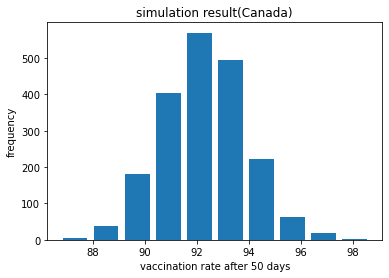

In [55]:
# we can see that our simulation result follows a very nice normal distribution
v50 = np.sum(r_speriod50 ,axis =1) + v0
# distribution of the simulations
hist, bins = histogram(v50)
positions = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 0.8
plt.bar(positions, hist, width=width)
plt.xlabel('vaccination rate after 50 days')
plt.ylabel('frequency')
plt.title('simulation result(Canada)')
plt.figsize=(4, 4)
plt.show()

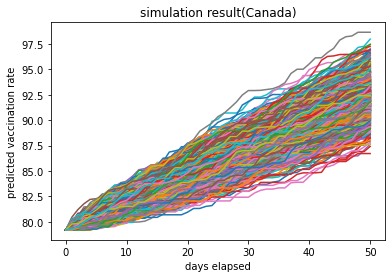

In [56]:
#plot the simulation projections
for scenario in r_speriod50:
    y = [np.sum(scenario[0:i]) + v0 for i in range(0,51)]
    plt.plot(range(0,51), y)
plt.xlabel('days elapsed')
plt.ylabel('predicted vaccination rate')
plt.title('simulation result(Canada)')
plt.show()

In [57]:
#best scenario
#max(v50)
percentile(v50, [99])[0]#using 99% confidence interval

96.35715839039648

In [58]:
#worst scenario
#min(v50)
percentile(v50, [1])[0]#using 99% confidence interval

88.69309316497686

In [59]:
#base scenario
#median(v50)
percentile(v50, [50])[0]

92.27913705543509

In [60]:
print('Our best case is {}%, worst case is {}%, base case is {}%.'.\
      format(round(percentile(v50, [99])[0],2),
             round(percentile(v50, [1])[0],2),round(percentile(v50, [50])[0],2)))

Our best case is 96.36%, worst case is 88.69%, base case is 92.28%.


In [61]:
# add results to our dataframe
df_result.loc['Canada','MC_best'] = round(percentile(v50, [99])[0],2)
df_result.loc['Canada','MC_worst'] = round(percentile(v50, [1])[0],2)
df_result.loc['Canada','MC_base'] = round(percentile(v50, [50])[0],2)

In [62]:
df_result

,MC_best,MC_base,MC_worst,ARIMA_best,ARIMA_base,ARIMA_worst
Canada,96.36,92.28,88.69,NaN,NaN,NaN
USA,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# so the expected number increase in vaccinated people in the next 50 days in Canada is
vi = int(population_canada * (df_result.loc['Canada','MC_base'] - v0)*0.01)
print('the expected number increase in vaccinated people in the next 50 days in Canada is {}'.format(vi))

the expected number increase in vaccinated people in the next 50 days in Canada is 4975247


We apply the same procedure for another chosen country: the US

the US

In [64]:
df_us = df[df['location'] == 'United States']
df_us.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
33346,United States,USA,2020-12-13,21800.0,18529.0,3875.0,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.000
33347,United States,USA,2020-12-14,26124.0,22716.0,3971.0,0.0,4324.0,4324.0,0.01,0.01,0.0,0.0,13.0,4187.0,0.001
33348,United States,USA,2020-12-15,74833.0,69226.0,4166.0,0.0,48709.0,26516.0,0.02,0.02,0.0,0.0,79.0,25348.0,0.008
33349,United States,USA,2020-12-16,233645.0,222604.0,4548.0,0.0,158812.0,70615.0,0.07,0.07,0.0,0.0,210.0,68025.0,0.020
33350,United States,USA,2020-12-17,504183.0,486107.0,5110.0,0.0,270538.0,120596.0,0.15,0.14,0.0,0.0,359.0,116894.0,0.035


In [65]:
#we can estimate the total number of populations for the US using the dataset as follows
population_us = int(df_us['people_vaccinated'].max()/(df_us['people_vaccinated_per_hundred'].max()*0.01))
population_us

336300735

In [66]:
# store the increase in vaccination rate
df_us['vr_increase'] = df_us['people_vaccinated_per_hundred']-df_us['people_vaccinated_per_hundred'].shift(1) 
df_us= df_us.drop(df_us[df_us['vr_increase'].isna()].index)# remove NANs 
df_us.index = np.arange(0,len(df_us))
print(df_us['vr_increase'])

0      0.00
1      0.01
2      0.05
3      0.07
4      0.12
       ... 
338    0.13
339    0.12
340    0.08
341    0.02
342    0.00
Name: vr_increase, Length: 343, dtype: float64


We want to predict the vaccination rate of Ameriacan people 50 days after the last date indicated in the dataframe.

So our initial vaccination rate should be 68.48% indicated in the last row in df

In [67]:
v0 = df_us['people_vaccinated_per_hundred'].max()
v0

68.48

In [68]:
mean_increase = float(df_us[['vr_increase']].mean())
std_increase = float(df_us[['vr_increase']].std())
print ("average increase in vaccination rate = {}, st. dev  = {}.".format(mean_increase, std_increase))

average increase in vaccination rate = 0.19962099125364433, st. dev  = 0.17015688262388243.


To use monte carlo simulation, we assume our increase in vaccination rate daily follows Gaussian distribution with mean and standard deviation specified above

Since it is possible to generate negative numbers, and the increase in the rate of vaccination should not be negative, we will fill negative numbers with 0 in our case.

In [69]:
# we create 2000 scenarios and random numbers follows Gaussian distribution 
# with mean and sd specified above
# Simulate 50 columns of 2000 observations each of single day increase:
Ns = 2000 # Number of scenarios
r_speriod50 = np.random.normal(mean_increase, std_increase, (Ns,50))
r_speriod50[r_speriod50<0] = 0
r_speriod50.shape

(2000, 50)

In [70]:
(np.sum( r_speriod50 ,axis =1) + v0)[:50]

array([80.62470324, 77.99474755, 77.55015311, 80.39173777, 77.43688421,
       78.49056996, 78.76915557, 78.05086294, 80.01411216, 78.82699993,
       78.70581757, 78.26521045, 77.92511385, 79.82239023, 79.05023687,
       79.09292387, 76.62372985, 79.73635202, 78.65034149, 78.87745076,
       78.42005675, 79.28434412, 77.746815  , 78.77854769, 79.57894909,
       80.23695599, 78.81201129, 77.83153519, 79.56232962, 80.54308304,
       80.41385398, 79.7461531 , 79.87259536, 80.23369395, 78.81103604,
       78.95379938, 80.26571523, 78.93452446, 76.65031412, 77.96965629,
       77.70781609, 80.96130481, 77.85845308, 78.91307737, 78.08192005,
       78.27426148, 79.64059922, 78.74010092, 77.49489288, 77.95294406])

In [71]:
len(np.sum( r_speriod50 ,axis =1) + v0)

2000

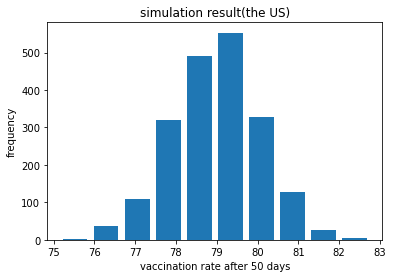

In [72]:
# we can see that our simulation result follows a very nice normal distribution
v50 = np.sum(r_speriod50 ,axis =1) + v0
# distribution of the simulations
hist, bins = histogram(v50)
positions = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 0.8
plt.bar(positions, hist, width=width)
plt.title('simulation result(the US)')
plt.xlabel('vaccination rate after 50 days')
plt.ylabel('frequency')
plt.show()

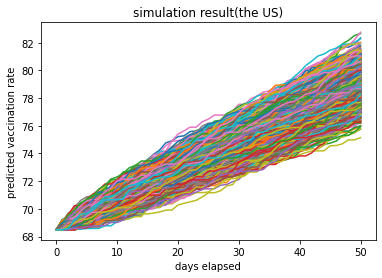

In [73]:
#plot the simulations
for scenario in r_speriod50:
    y = [np.sum(scenario[0:i]) + v0 for i in range(0,51)]
    plt.plot(range(0,51), y)
plt.xlabel('days elapsed')
plt.ylabel('predicted vaccination rate')
plt.title('simulation result(the US)')
#plt.gcf().set_size_inches(3, 1.75, forward=True)

plt.show()

In [74]:
#best scenario
#max(v50)
percentile(v50, [99])[0]#using 99% confidence interval

81.44210186138422

In [75]:
#worst scenario
#min(v50)
percentile(v50, [1])[0]#using 99% confidence interval

76.37748311810081

In [76]:
#base scenario
#median(v50)
percentile(v50, [50])[0]

79.01561091754692

In [77]:
print('Our best case is {}%, worst case is {}%, base case is {}%.'.\
      format(round(percentile(v50, [99])[0],2),
             round(percentile(v50, [1])[0],2),round(percentile(v50, [50])[0],2)))

Our best case is 81.44%, worst case is 76.38%, base case is 79.02%.


In [78]:
# add results to our dataframe
df_result.loc['USA','MC_best'] = round(percentile(v50, [99])[0],2)
df_result.loc['USA','MC_worst'] = round(percentile(v50, [1])[0],2)
df_result.loc['USA','MC_base'] = round(percentile(v50, [50])[0],2)
df_result

,MC_best,MC_base,MC_worst,ARIMA_best,ARIMA_base,ARIMA_worst
Canada,96.36,92.28,88.69,NaN,NaN,NaN
USA,81.44,79.02,76.38,NaN,NaN,NaN


In [79]:
# so the expected number increase in vaccinated people in the next 50 days in the US is
vi = int(population_us * (df_result.loc['USA','MC_base'] - v0)*0.01)
print('the expected number increase in vaccinated people in the next 50 days in the US is {}'.format(vi))

the expected number increase in vaccinated people in the next 50 days in the US is 35446097


we will also try the arima model to compare the results with the monte carlo simulation model

Since Arima model is a time series model taking into account the past patterns of data, it might be a good model in our case.

ARIMA

First let's apply the model on Canada

In [80]:
df_canada = df[df['location'] == 'Canada'] 
df_canada

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
5097,Canada,CAN,2020-12-14,5.0,5.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000
5098,Canada,CAN,2020-12-15,727.0,727.0,0.0,0.0,722.0,722.0,0.00,0.00,0.00,0.00,19.0,722.0,0.002
5099,Canada,CAN,2020-12-16,3016.0,3016.0,0.0,0.0,2289.0,1506.0,0.01,0.01,0.00,0.00,40.0,1506.0,0.004
5100,Canada,CAN,2020-12-17,7267.0,7267.0,0.0,0.0,4251.0,2421.0,0.02,0.02,0.00,0.00,64.0,2421.0,0.006
5101,Canada,CAN,2020-12-18,11276.0,11276.0,0.0,0.0,4009.0,2818.0,0.03,0.03,0.00,0.00,74.0,2818.0,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5435,Canada,CAN,2021-11-17,59776509.0,30102545.0,28764923.0,909041.0,76112.0,61164.0,157.03,79.08,75.56,2.39,1607.0,14376.0,0.038
5436,Canada,CAN,2021-11-18,59852559.0,30121803.0,28795770.0,934986.0,76050.0,66659.0,157.23,79.13,75.64,2.46,1751.0,15696.0,0.041
5437,Canada,CAN,2021-11-19,59918117.0,30136287.0,28821607.0,960223.0,65558.0,62649.0,157.40,79.16,75.71,2.52,1646.0,14717.0,0.039
5438,Canada,CAN,2021-11-20,59947684.0,30145291.0,28837538.0,964855.0,29567.0,62168.0,157.48,79.19,75.75,2.53,1633.0,14706.0,0.039


In [81]:
# get the vaccination rate of Canada in sequence of time
vr = df_canada['people_vaccinated_per_hundred'].values

Normally, we need to detrend or remove the seasonality in the data by using differencing(d) otherwise there will be noise that interfere our analysis. 

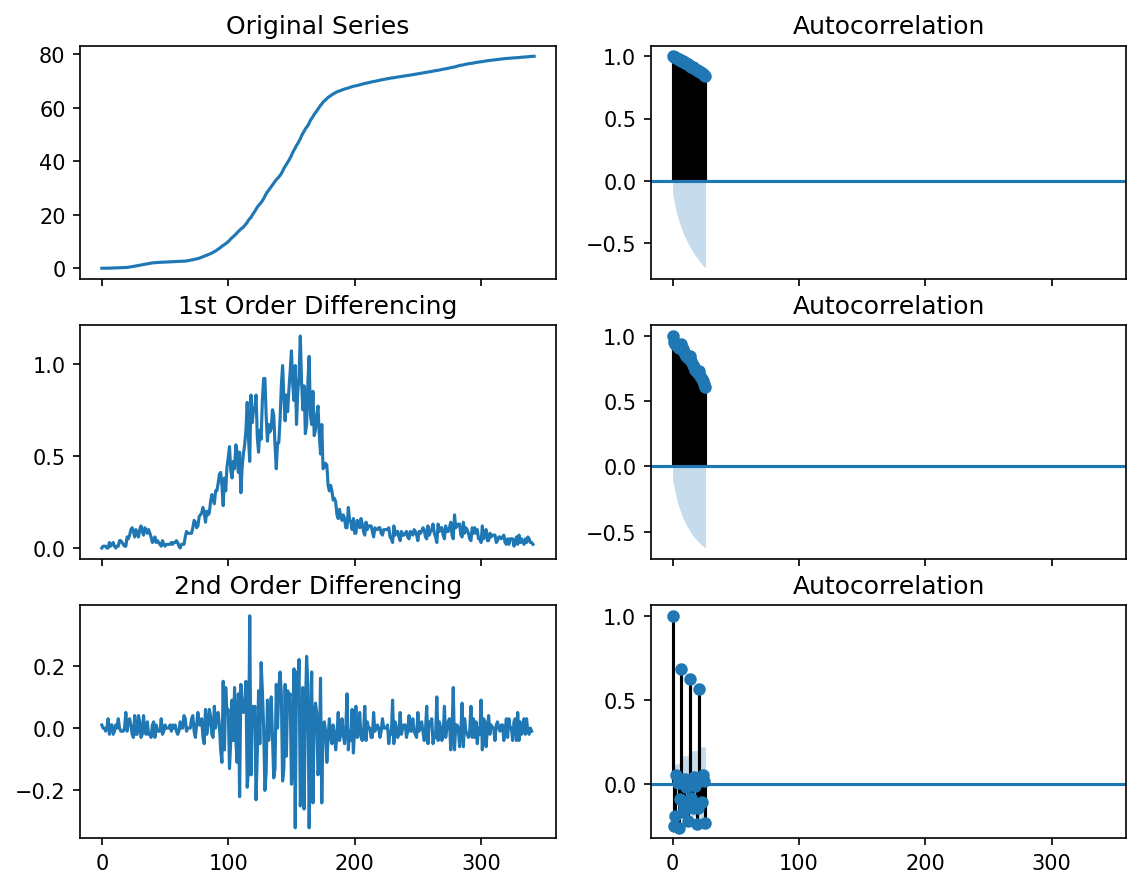

In [82]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':150})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(vr); axes[0, 0].set_title('Original Series')
plot_acf(vr, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(vr)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(vr), ax=axes[1, 1])
diffvr = np.diff(vr)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffvr)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffvr), ax=axes[2, 1])
#plt.show()

"""
# 3rd Differencing
diffvr2 = np.diff(diffvr)
axes[3, 0].plot(np.diff(diffvr2)); axes[3, 0].set_title('3nd Order Differencing')
plot_acf(np.diff(diffvr2), ax=axes[3, 1])
"""
plt.show()

We can see that we have some lags well above the significance line for original series as well as the series after first order differencing. After the second differencing, we keep most of the lags in the significance region.(the zoomed in version of acf plots below are more clear)

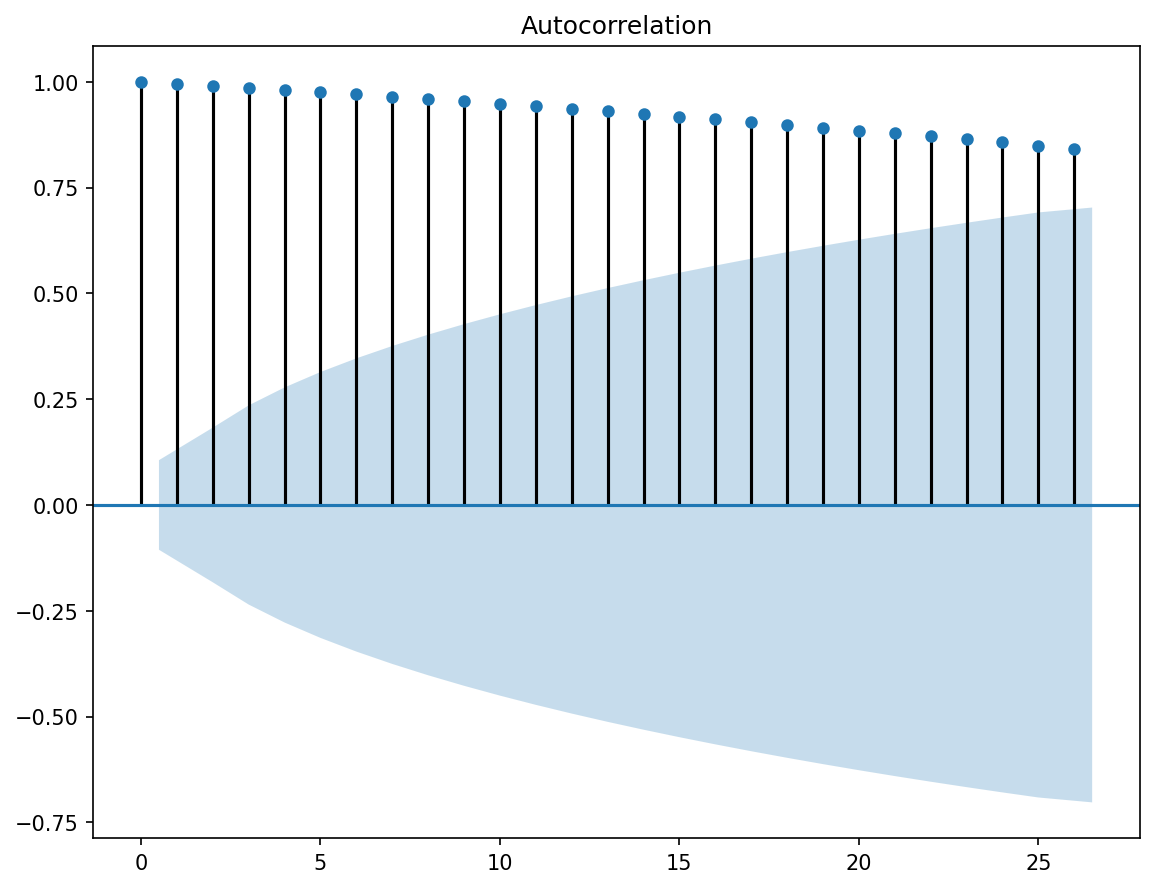

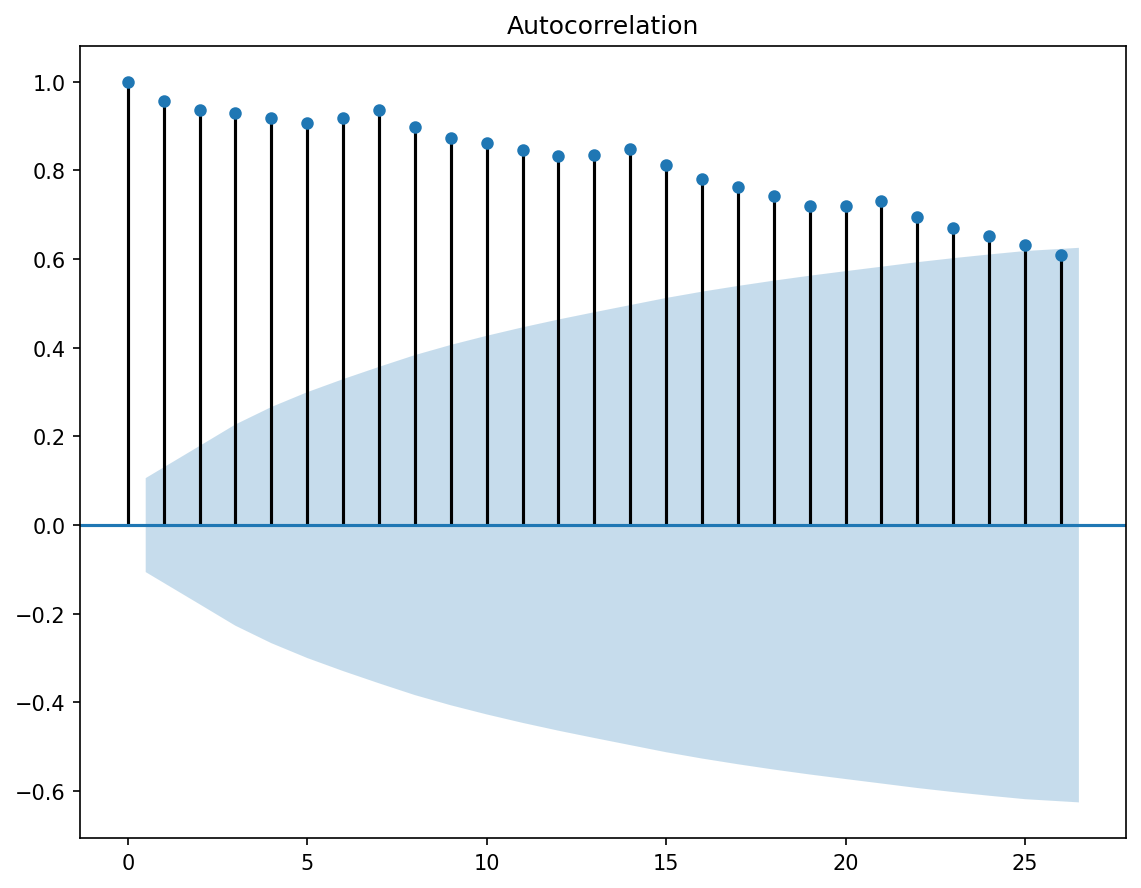

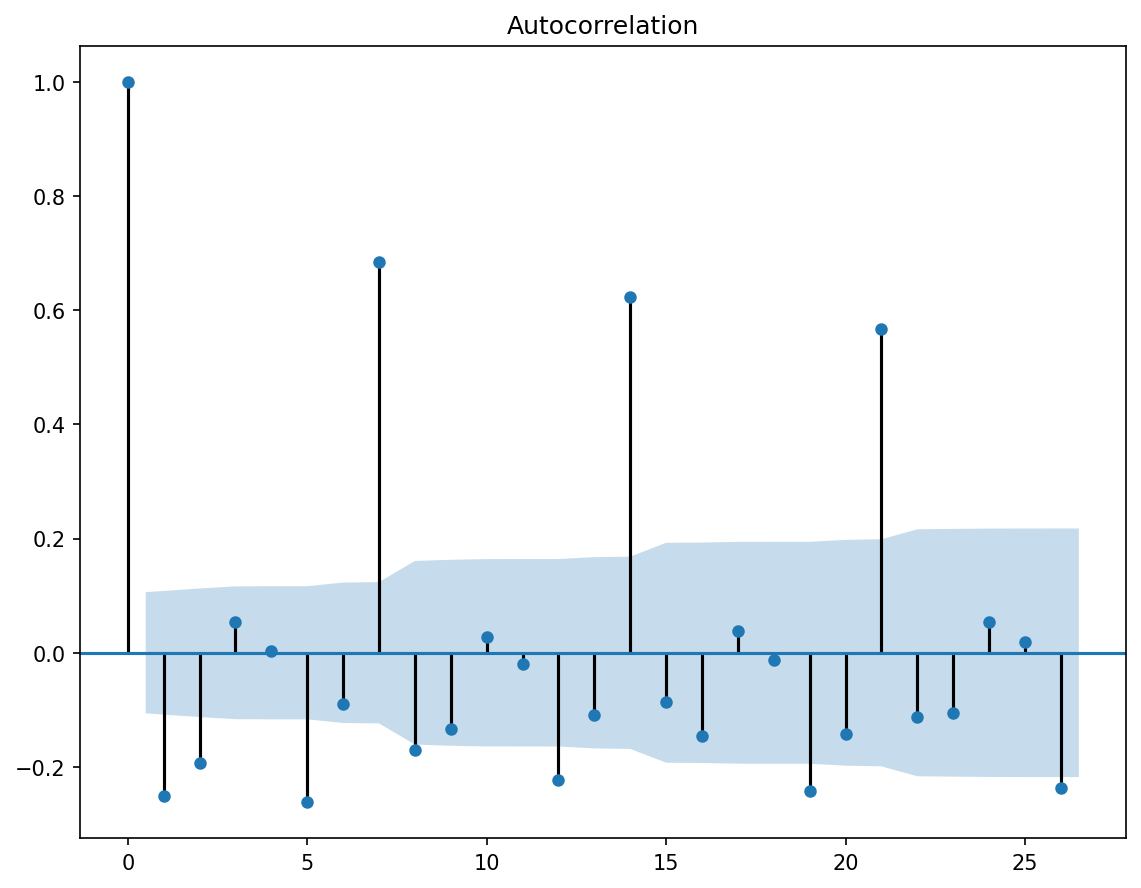

In [83]:
# the above acf plot is not very clear, we zoom in the autocorrelation plots as follows.
plot_acf(vr)
plot_acf(np.diff(vr))
plot_acf(np.diff(diffvr))
plt.show()

As mentioned in the example, ARIMA model consists of 3 parts, AR model, differencing and MA model. They are controlled by 3 parameters: p, d and q respectively. p is the number of lags of Y to be used as predictors. And q is the number of lagged forecast errors that should go into the ARIMA Model. We will use auto arima model to do a grid search for finding the best combination of these 3 parameters. The best model is determined using AIC calculated by the system. The lower the AIC the better the model. The complexity of the model and how well the model fits the data determines the AIC value.

In [84]:
model = pm.auto_arima(vr, trace= True, suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-829.925, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-776.375, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-796.401, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-819.566, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-831.934, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-833.339, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-831.975, Time=0.16 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-829.548, Time=0.08 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-836.736, Time=0.34 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-873.958, Time=0.44 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-893.199, Time=0.47 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-835.042, Time=0.39 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=-840.555, Time=0.47 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=-866.791, Time=0.58 sec
 ARIMA(2,2,4)(0,0,0)[0]          

The auto arima model determines to use 5 lags(previous data) as well as 4 error terms and 2nd order differencing as we discussed above. It means there is some obvious trend that the model have to be dealt with. The p-value of most of the ar and ma terms are lower to 0.05 which is good. There is only one term: lag3 of autoregression model has a p-value over 0.05, but it is still lower than 0.1 which is acceptable. sigma2 is the standaed deviation of the predicted model and it is very small.

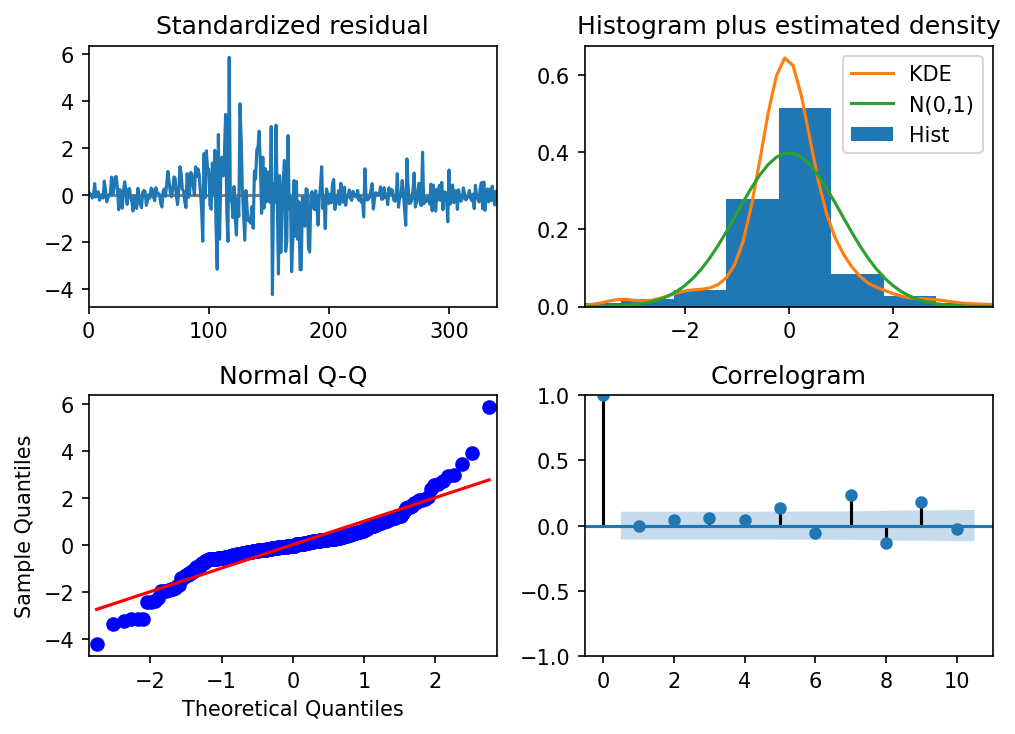

In [85]:
model.plot_diagnostics(figsize=(7,5))
plt.tight_layout()# avoid overlapping of subplot titles and x labels
plt.show()

The residual errors seem to fluctuate around a mean of zero and have a uniform variance.The model prediction has very small error.

The (distribution of residual)density plot suggests normal distribution with mean zero. It means the model prediction is very close to the actual label/value.

Normal Q-Q suggests that the distribution at the 2 sides is a little bit skewed but still in good shape. The theoretical quantiles and sample quantiles follow the sample direction.

There are some autocorrelation beween residual errors that are not explained by the model. We may need more predictors for the model and our model may not be powerful enough to capture all the patterns in the data. But most of them are inside the significance region, which means our model does have some abilities in capturing patterns and in predicting.



So based on the above explanation, predicting using our model is reliable.

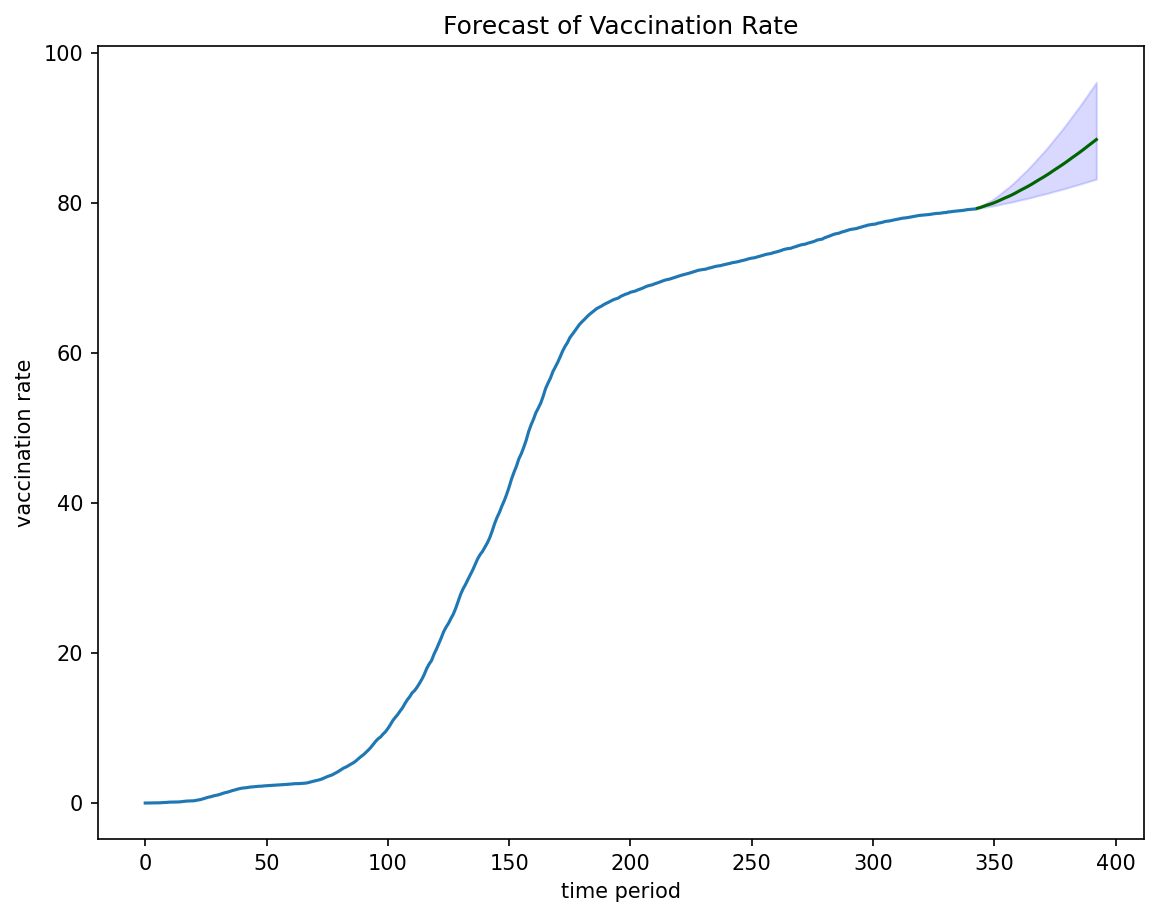

The best case has a vaccination rate of 96.09
The base case has a vaccination rate of 88.47
The worst case has a vaccination rate of 83.19


In [86]:
# Forecast
n_periods = 50

#I use alpha = 0.01 for best case, 0.2 for base case, and 0.7 for worst case.
#(only use right hand side value of confidence interval)
#This is because the model in this case may predict a decreasing trend in vaccination rate
#and as we know from the dataset, the vaccination rate cannot decrease.
#we have to make sure that the predicted rate for each period is always 
#greater than or equal to the rate for the previous period.
fc1, confint1 = model.predict(n_periods=n_periods, return_conf_int=True,alpha = 0.01)
fc2, confint2 = model.predict(n_periods=n_periods, return_conf_int=True,alpha = 0.7)
fc3, confint3 = model.predict(n_periods=n_periods, return_conf_int=True,alpha = 0.2)
index_of_fc = np.arange(len(vr), len(vr)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(confint3[:, 1], index=index_of_fc)
lower_series = pd.Series(confint2[:, 1], index=index_of_fc)
upper_series = pd.Series(confint1[:, 1], index=index_of_fc)

# Plot
plt.plot(vr)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of Vaccination Rate")
plt.xlabel('time period')
plt.ylabel('vaccination rate')
plt.show()

# use [-1] to get the prediction on the 50th/last day, and round the result to 2 decimal place
print("The best case has a vaccination rate of {}".format(round(list(upper_series)[-1],2)))
print("The base case has a vaccination rate of {}".format(round(list(fc_series)[-1],2)))
print("The worst case has a vaccination rate of {}".format(round(list(lower_series)[-1],2)))

As shown above, the green line indicates the base case, the confidence interval gives the best case and the worst case. Since we cannot have negative increase in the vaccination rate, I use smaller alphas for confidence intervals 

In [87]:
# add results to our dataframe
df_result.loc['Canada','ARIMA_best'] = round(list(upper_series)[-1],2)
df_result.loc['Canada','ARIMA_worst'] = round(list(lower_series)[-1],2)
df_result.loc['Canada','ARIMA_base'] = round(list(fc_series)[-1],2)
df_result

,MC_best,MC_base,MC_worst,ARIMA_best,ARIMA_base,ARIMA_worst
Canada,96.36,92.28,88.69,96.09,88.47,83.19
USA,81.44,79.02,76.38,NaN,NaN,NaN


In [88]:
# so the expected number increase in vaccinated people in the next 50 days in Canada is
vi = int(population_canada * (df_result.loc['Canada','ARIMA_base'] - df_canada['people_vaccinated_per_hundred'].max())*0.01)
print('the expected number increase in vaccinated people in the next 50 days in Canada is {}'.format(vi))

the expected number increase in vaccinated people in the next 50 days in Canada is 3524926


Next, we applied ARIMA model on the US's vaccination rate

In [89]:
df_us = df[df['location'] == 'United States'] 
df_us

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
33346,United States,USA,2020-12-13,21800.0,18529.0,3875.0,0.0,0.0,0.0,0.01,0.01,0.00,0.00,0.0,0.0,0.000
33347,United States,USA,2020-12-14,26124.0,22716.0,3971.0,0.0,4324.0,4324.0,0.01,0.01,0.00,0.00,13.0,4187.0,0.001
33348,United States,USA,2020-12-15,74833.0,69226.0,4166.0,0.0,48709.0,26516.0,0.02,0.02,0.00,0.00,79.0,25348.0,0.008
33349,United States,USA,2020-12-16,233645.0,222604.0,4548.0,0.0,158812.0,70615.0,0.07,0.07,0.00,0.00,210.0,68025.0,0.020
33350,United States,USA,2020-12-17,504183.0,486107.0,5110.0,0.0,270538.0,120596.0,0.15,0.14,0.00,0.00,359.0,116894.0,0.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33685,United States,USA,2021-11-17,449028238.0,229584222.0,194561634.0,33834775.0,1479995.0,1297921.0,133.51,68.26,57.85,10.06,3859.0,444416.0,0.132
33686,United States,USA,2021-11-18,450381454.0,229972864.0,194694936.0,34677686.0,1353216.0,1288385.0,133.91,68.38,57.89,10.31,3831.0,427578.0,0.127
33687,United States,USA,2021-11-19,451355421.0,230255670.0,194788580.0,35282993.0,973967.0,1174321.0,134.20,68.46,57.92,10.49,3492.0,383614.0,0.114
33688,United States,USA,2021-11-20,451453834.0,230298744.0,194797007.0,35329604.0,98413.0,1039368.0,134.23,68.48,57.92,10.50,3090.0,321539.0,0.096


In [90]:
# get the vaccination rate of the US in sequence of time
vr = df_us['people_vaccinated_per_hundred'].values

Normally, we need to detrend or remove the seasonality in the data by using differencing(d) otherwise there will be noise that interfere our analysis.



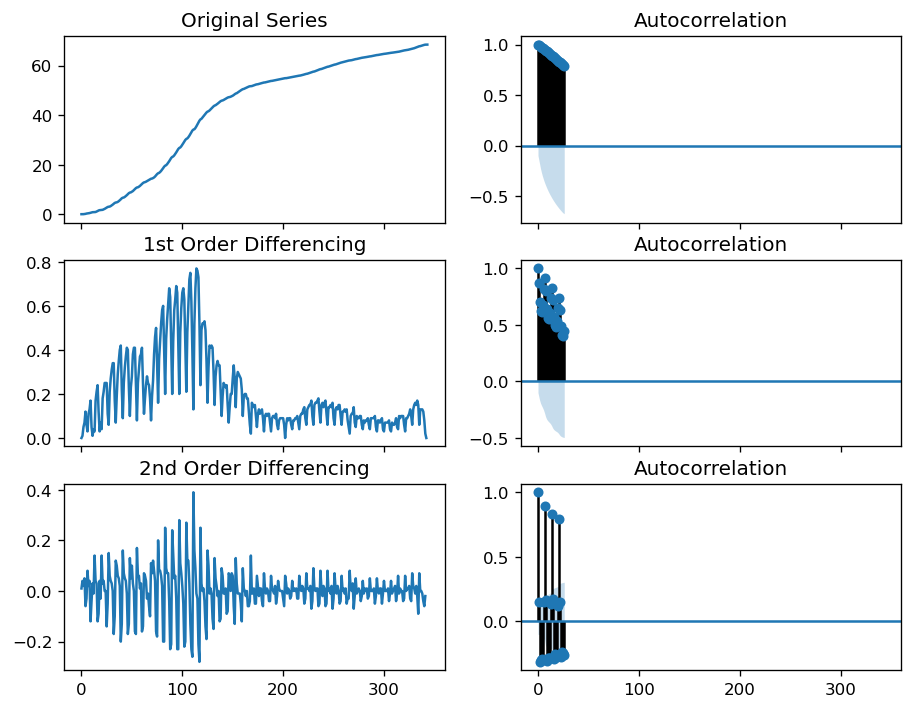

In [91]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(vr); axes[0, 0].set_title('Original Series')
acf1 = plot_acf(vr, ax=axes[0, 1])
#.set_xlim([0, 50])
#plt.gcf().get_axes()[1].set_xlim(0,50)

# 1st Differencing
axes[1, 0].plot(np.diff(vr)); axes[1, 0].set_title('1st Order Differencing')
acf2 = plot_acf(np.diff(vr), ax=axes[1, 1])
#acf2.set_xlim([0, 50])
diffvr = np.diff(vr)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffvr)); axes[2, 0].set_title('2nd Order Differencing')
acf3 = plot_acf(np.diff(diffvr), ax=axes[2, 1])
#acf3.set_xlim([0, 50])
#plt.show()

"""
# 3rd Differencing
diffvr2 = np.diff(diffvr)
axes[3, 0].plot(np.diff(diffvr2)); axes[3, 0].set_title('3nd Order Differencing')
plot_acf(np.diff(diffvr2), ax=axes[3, 1])
"""
plt.show()

We can see that we have some lags well above the significance line for original series as well as the series after first order differencing. After the second differencing, we keep most of the lags in the significance region.(The zoomed in version of acf plots below are more clear)

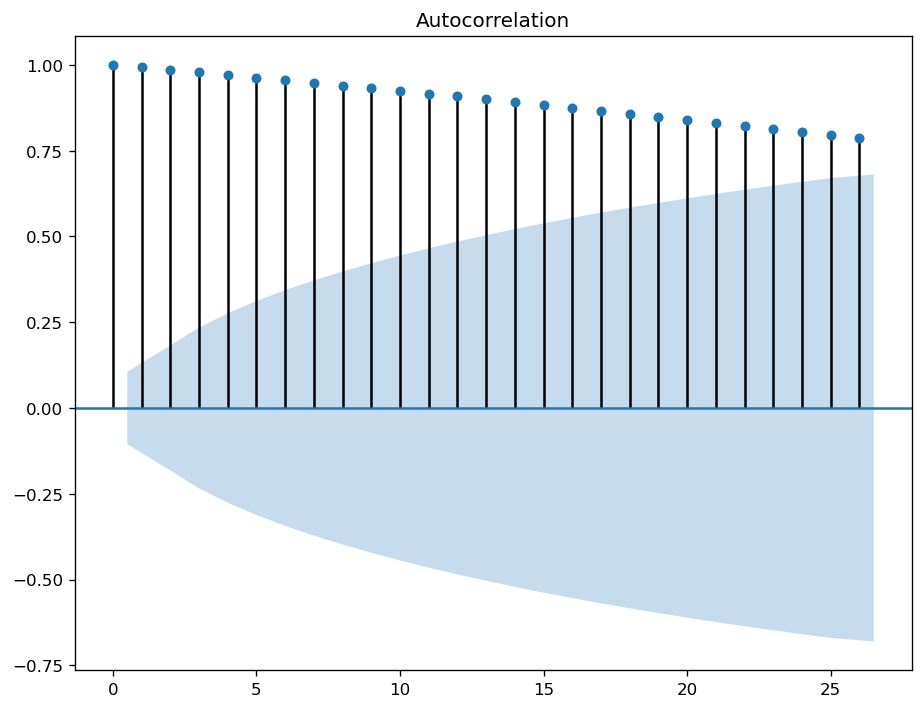

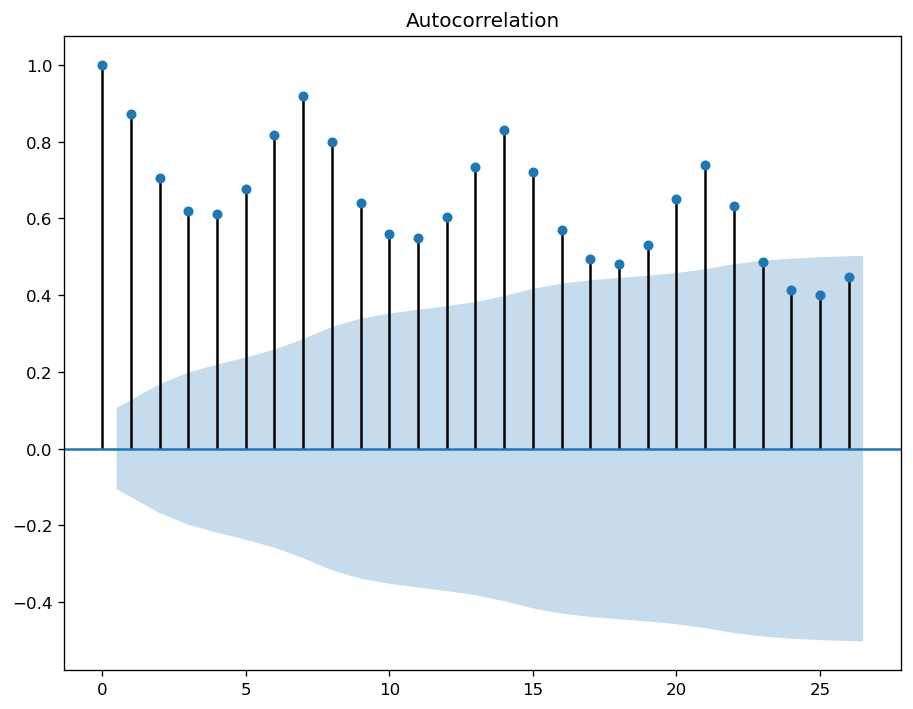

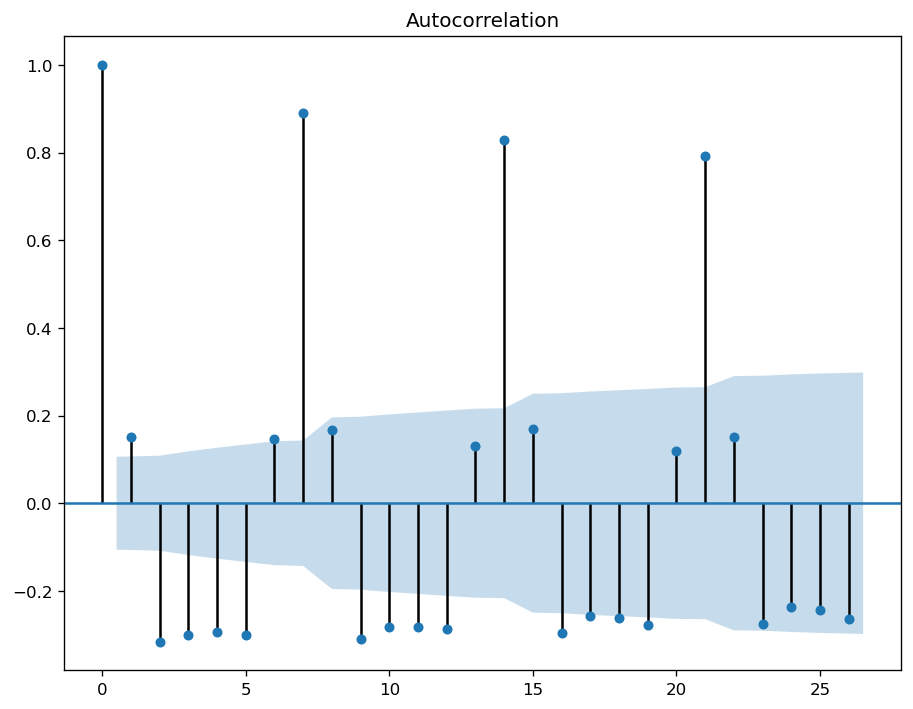

In [92]:
# the above acf plot is not very clear, we zoom in the autocorrelation plots as follows.
plot_acf(vr)
plot_acf(np.diff(vr))
plot_acf(np.diff(diffvr))
plt.show()

In [93]:
model = pm.auto_arima(vr, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=5, max_q=5, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-748.796, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-711.986, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-717.905, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-727.220, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-713.986, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-846.815, Time=0.27 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-759.470, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-855.893, Time=0.39 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-773.471, Time=0.17 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-909.189, Time=0.61 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-827.563, Time=0.23 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-993.494, Time=0.77 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-969.840, Time=0.53 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=-1095.548, Time=0.92 sec
 ARIMA(4,2,2)(0,0,0)[0] intercep

The auto arima model determines to use 5 lags(previous data), 4 error terms and 2nd order differencing which is the same as we discussed above. It means there is obvious trend that have to be dealt with. The p-value of all the ar and ma terms are lower to 0.05 which is good. sigma2 is the standaed deviation of the predicted model and it is very small. 

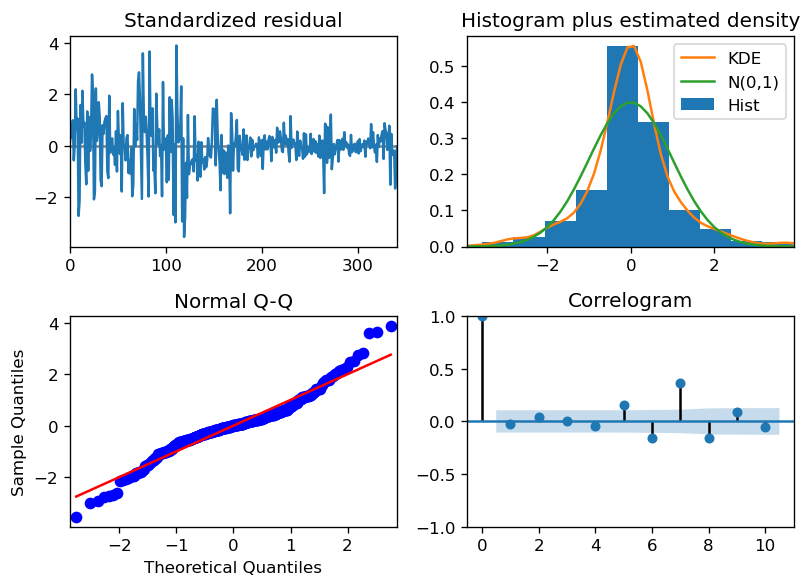

In [94]:
model.plot_diagnostics(figsize=(7,5))
plt.tight_layout()# avoid overlapping of subplot titles and x labels
plt.show()

The residual errors seem to fluctuate around a mean of zero and have a uniform variance.The model prediction has small error.

The (distribution of residual)density plot suggests normal distribution with mean zero. It means the model prediction is very close to the actual label/value.

Normal Q-Q suggests that the distribution at the 2 sides is a little bit skewed but still in good shape. The theoretical quantiles and sample quantiles follow the sample direction.

There are some autocorrelation beween residual errors that are not explained by the model. We may need more predictors for the model and our model may not be powerful enough to capture all the patterns in the data. But most of them are inside the significance region, which means our model does have some abilities in capturing patterns and in predicting. When setting max_p < 5, there are many residual autocorrelations that are well above or below the significance region, which means model with p < 5 is far worse than model with p = 5 in capturing the patterns in the data. And to prevent overfitting, we set max_p = 5 and not greater than 5.

So based on the above explanation, predicting using our model is reliable.

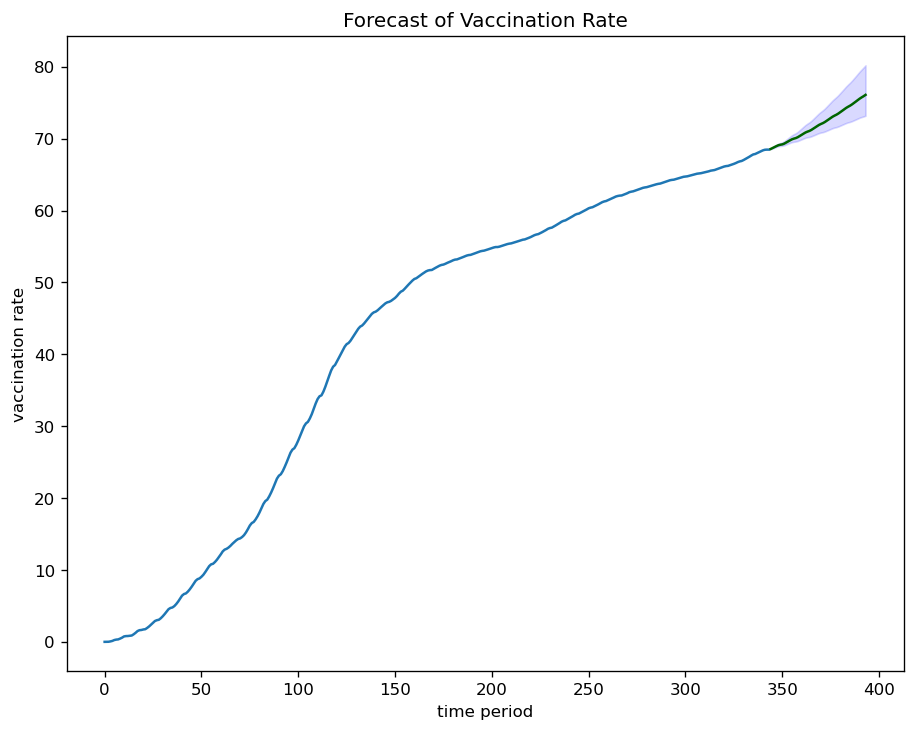

The best case has a vaccination rate of 80.21046388696445
The base case has a vaccination rate of 76.09566093489535
The worst case has a vaccination rate of 73.19461857374725


In [95]:
# Forecast
n_periods = 50
#I use alpha = 0.05 for best case, 0.3 for base case, and 0.7 for worst case.(only use right hand side predictions of CI)
#This is because the model in this case may predict a decreasing trend in vaccination rate
#and as we know from the dataset, the vaccination rate cannot decrease.
#we have to make sure the predicted rate for each period is always greater than or equal to the rate for the previous period.
fc1, confint1 = model.predict(n_periods=n_periods, return_conf_int=True,alpha = 0.05)
fc2, confint2 = model.predict(n_periods=n_periods, return_conf_int=True,alpha = 0.3)
fc3, confint3 = model.predict(n_periods=n_periods, return_conf_int=True,alpha = 0.7)
index_of_fc = np.arange(len(vr), len(vr)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(confint2[:,1], index=index_of_fc)
lower_series = pd.Series(confint3[:, 1], index=index_of_fc)
upper_series = pd.Series(confint1[:, 1], index=index_of_fc)

# Plot
plt.plot(vr)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.xlabel('time period')
plt.ylabel('vaccination rate')
plt.title("Forecast of Vaccination Rate")
plt.show()

# use [-1] to get the prediction on the 50th/last day, and round the result to 2 decimal place
print("The best case has a vaccination rate of {}".format(list(upper_series)[-1]))
print("The base case has a vaccination rate of {}".format(list(fc_series)[-1]))
print("The worst case has a vaccination rate of {}".format(list(lower_series)[-1]))

In [96]:
# add results to our dataframe
df_result.loc['USA','ARIMA_best'] = round(list(upper_series)[-1],2)
df_result.loc['USA','ARIMA_worst'] = round(list(lower_series)[-1],2)
df_result.loc['USA','ARIMA_base'] = round(list(fc_series)[-1],2)
df_result

,MC_best,MC_base,MC_worst,ARIMA_best,ARIMA_base,ARIMA_worst
Canada,96.36,92.28,88.69,96.09,88.47,83.19
USA,81.44,79.02,76.38,80.21,76.1,73.19


In [97]:
# so the expected number increase in vaccinated people in the next 50 days in the US is
vi = int(population_us * (df_result.loc['USA','ARIMA_base'] - df_us['people_vaccinated_per_hundred'].max())*0.01)
print('the expected number increase in vaccinated people in the next 50 days in the US is {}'.format(vi))

the expected number increase in vaccinated people in the next 50 days in the US is 25626116


Now we get the results of both Monte Carlo simulation model and ARIMA model on predicting the vaccination rate of the US and Canada in the next 50 days, we can discuss the results a bit here.

We can see from the df that the two models gives very similar vaccination rate prediction for the US and Canada. But strictly speaking, the predictions of the 2 models for Canada differs more than for the US. We can see very clearly from the 2 forcast plots in the last part that Canada and the US have very similar curves for vaccination rate. Their vaccination rates first increase very fast to a certain limit(time period 150-200) and they start to increase with lower rate. But there is a big difference dispite they have similar vaccination curves. Canada's vaccination rate has a very fast rate of increase until around 70% vaccination rate and then the rate of increase started to fall. But for the US, it is 50%. This means although they all have high rate of increase at the middle, Canada's rate(period 100-200) is greater and it nearly approches exponential. This difference might explain why the 2 models have different predictions for Canada. 

Monte Carlo simulation model generate the daily increase in vaccination rate based on Guassian distribution. We input the past increase in vaccination rates and generate random numbers using the mean and standard devisation of the past data. We then simulate the prediction 2000 times to create reliable predictions. There is no pattern learning involved.
Arima model is based on the lags, differencing and past error terms and it takes into account the patterns of the past data.

The 2 models have their pros and cons:
The advantage of using Monte Carlo simulation model is that it can factor a range of values for various inputs.
The disadvantage is that we may get overly optimistic result bacause compared to Arima model, Monte Carlo simulation model cannot 'learn' patterns, it generates prediction solely based on the random numbers generated using the mean and standard deviation from past data. Our past data also needs to be reliable otherwise we get bad prediction. 

The advantage of using Arima model is that it is based on more systematic variables such as lags and errors instead of randomly generated numbers. So it can 'learn' the pattern of past data and give more reliable result.
The disadvantage in our case is that vaccination rate must be increasing but we cannot control Arima model to do that. It predicts using past 'experience' and ignore other important constrains(such as total vaccinations and vaccination rates must be increasing).

So in this case, since our vaccination rate has a changing rate of increase, We may want to use the result that coming from a model that can 'learn' past patterns such as Arima model. Its result might be more reliable than Monte Carlo simulation model.

In [124]:
df_complete

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134454,ZWE,Africa,Zimbabwe,2021-11-15,133438.0,10.0,33.286,4697.0,1.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
134455,ZWE,Africa,Zimbabwe,2021-11-16,133505.0,67.0,37.571,4698.0,1.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
134456,ZWE,Africa,Zimbabwe,2021-11-17,133557.0,52.0,36.429,4699.0,1.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
134457,ZWE,Africa,Zimbabwe,2021-11-18,133593.0,36.0,37.714,4699.0,0.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


## PART4 Relating COVID-19 Vaccination to a Second Dataset

In [98]:
df_complete = pd.read_csv("Complete_covid19_dataset.csv")
df_complete.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [99]:
# we are only interested in the 2 countries we selected in the previous part.
df_canada2 = df_complete[df_complete['iso_code']=='CAN']
df_us2 = df_complete[df_complete['iso_code']=='USA']

In [100]:
# we are interested in the relationship between 'new_cases' and the vaccination rate.
df_canada2 = df_canada2[['location','date','new_cases']].dropna()

In [101]:
df_us2 = df_us2[['location','date','new_cases']].dropna()

we will join the new_cases data with the vaccination rate data using 'date' as the key

In [102]:
df_canada_data = pd.merge(df_canada2,df_canada[['date','people_vaccinated_per_hundred']], how='inner', on=['date'])\
.drop('location',axis = 1).reset_index(drop=True)
df_canada_data

,date,new_cases,people_vaccinated_per_hundred
0,2020-12-14,8645.0,0.00
1,2020-12-15,6291.0,0.00
2,2020-12-16,6733.0,0.01
3,2020-12-17,7467.0,0.02
4,2020-12-18,7045.0,0.03
...,...,...,...
336,2021-11-15,4370.0,78.99
337,2021-11-16,1816.0,79.02
338,2021-11-17,2526.0,79.08
339,2021-11-18,2798.0,79.13


In [103]:
df_us_data = pd.merge(df_us2,df_us[['date','people_vaccinated_per_hundred']], how='inner', on=['date'])\
.drop('location',axis = 1).reset_index(drop=True)
df_us_data

,date,new_cases,people_vaccinated_per_hundred
0,2020-12-13,186705.0,0.01
1,2020-12-14,200631.0,0.01
2,2020-12-15,222052.0,0.02
3,2020-12-16,240691.0,0.07
4,2020-12-17,237229.0,0.14
...,...,...,...
337,2021-11-15,138787.0,68.00
338,2021-11-16,87586.0,68.13
339,2021-11-17,111404.0,68.26
340,2021-11-18,109578.0,68.38


now we get our datasets for the 2 countries, we can now perform our analysis

analysis of relationship between the number of new COVID-19 cases and the rate of vaccination in Canada

In [104]:
# 'new_cases' and 'people_vaccinated_per_hundred' are negatively correlated
df_canada_data.corr()

,new_cases,people_vaccinated_per_hundred
new_cases,1.000000,-0.516251
people_vaccinated_per_hundred,-0.516251,1.000000


The Pearson correlation coefficient measures the linear relationship between two datasets.

H0:There is no linear relationship between 'new_cases' and 'people_vaccinated_per_hundred'

In [105]:
stats.pearsonr(df_canada_data.new_cases.dropna(), df_canada_data.people_vaccinated_per_hundred.dropna())[1]

1.2705175337806741e-24

Since the p-value < 0.05, we reject the null hypothesis and conclude that there is a significant linear relationship between 'new_cases' and 'people_vaccinated_per_hundred'

we can make a scatterplot to see their relationship

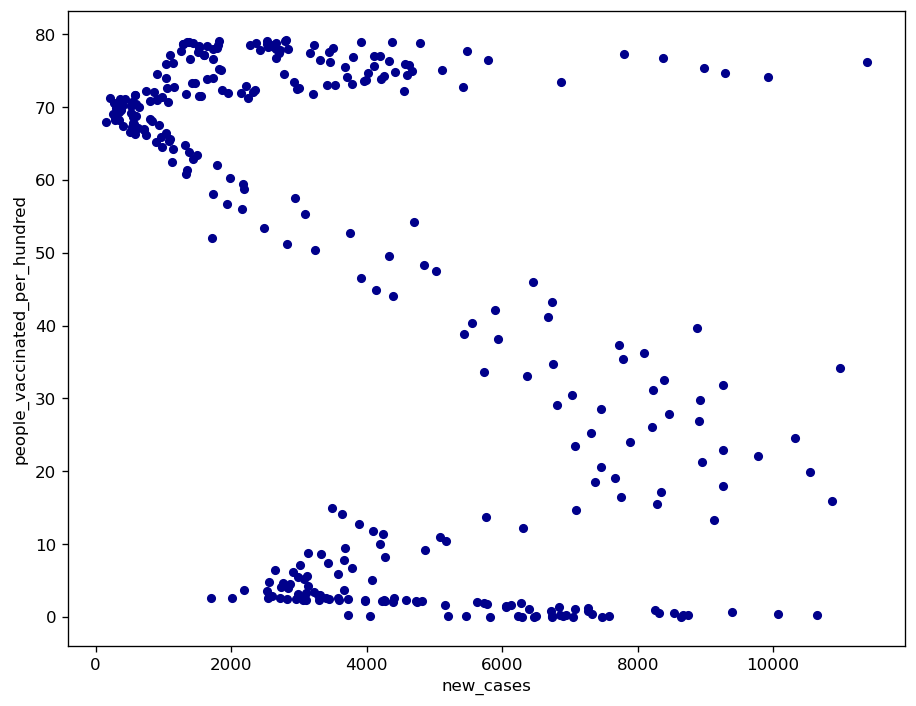

In [106]:
df_canada_data.plot.scatter(x='new_cases',y='people_vaccinated_per_hundred', c='DarkBlue')

It seems that the 2 variables has some non linear relationship, we will use linear regression to test if the relashionship is linear or non-linear by looking at the loss.

we will first split the train and test set.

In [107]:
# it is time series data, we do not want to shuffle it or change its sequence. we do the split manually
threshold = int(.7 * len(df_canada_data))# use 70% training, 30% testing
x_train = df_canada_data['new_cases'].values[:threshold].reshape(-1, 1)
y_train = df_canada_data['people_vaccinated_per_hundred'].values[:threshold].reshape(-1, 1)
x_test = df_canada_data['new_cases'].values[threshold:].reshape(-1, 1)
y_test = df_canada_data['people_vaccinated_per_hundred'].values[threshold:].reshape(-1, 1)

we use sklearn.preprocessing.PolynomialFeatures to transfer linear features to higher dimensions.

Polynomial regression is a form of Linear regression where only due to the Non-linear relationship between dependent and independent variables. We add some polynomial terms to linear regression to convert it into Polynomial regression.

Polynomial Regression is also called Polynomial Linear Regression.

In [108]:
def regression_model_accuracy(degree):
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    x_train_trans = poly.fit_transform(x_train)
    x_test_trans = poly.transform(x_test)
    lr = LinearRegression()
    lr.fit(x_train_trans, y_train)
    y_pred = lr.predict(x_test_trans)
    print("degree = {0}, error = {1}".format(degree, mean_absolute_error(y_test,y_pred)))

In [109]:
for i in range(1,16):
    regression_model_accuracy(degree = i)

degree = 1, error = 40.377302866953045
degree = 2, error = 44.30464839744698
degree = 3, error = 48.2389369608874
degree = 4, error = 47.92322957683981
degree = 5, error = 47.099834934407895
degree = 6, error = 43.858312769294656
degree = 7, error = 41.628412949075305
degree = 8, error = 40.36826873906552
degree = 9, error = 39.97847638617926
degree = 10, error = 40.139032595750365
degree = 11, error = 40.585062753826456
degree = 12, error = 41.21405592648076
degree = 13, error = 41.9646011720437
degree = 14, error = 42.77837665401874
degree = 15, error = 43.669099298127364


We are surprised to find that the linear model is as good as or even outperform many polynomial models we tested above(relatively low mae).

we can use the linear regression for modelling the relationship between the number of new COVID-19 cases and the rate of vaccination in Canada

Next we will perform analysis of relationship between the number of new COVID-19 cases and the rate of vaccination in the US

In [110]:
# 'new_cases' and 'people_vaccinated_per_hundred' are negatively correlated
df_us_data.corr()

,new_cases,people_vaccinated_per_hundred
new_cases,1.000000,-0.381354
people_vaccinated_per_hundred,-0.381354,1.000000


The Pearson correlation coefficient measures the linear relationship between two datasets.

H0:There is no linear relationship between 'new_cases' and 'people_vaccinated_per_hundred'

In [111]:
stats.pearsonr(df_us_data.new_cases.dropna(), df_us_data.people_vaccinated_per_hundred.dropna())

(-0.38135352947789564, 2.78253631754361e-13)

Since the p-value < 0.05, we reject the null hypothesis and conclude that there is a significant linear relationship between 'new_cases' and 'people_vaccinated_per_hundred'

we can make a scatterplot to see their relationship

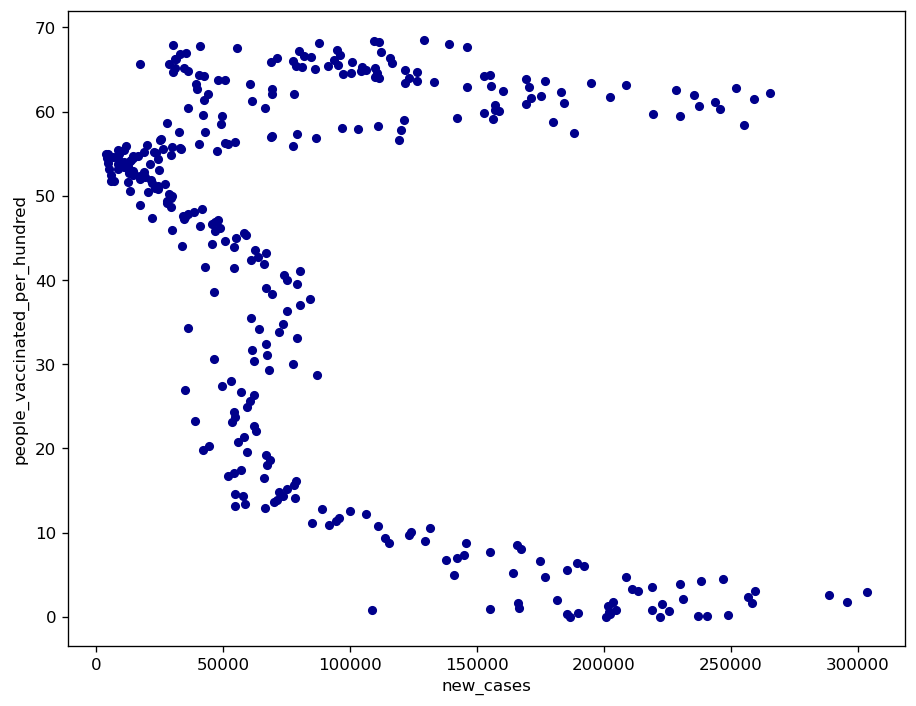

In [112]:
df_us_data.plot.scatter(x='new_cases',y='people_vaccinated_per_hundred', c='DarkBlue')

The relationship is non_linear either

In [113]:
# it is time series data, we do not want to shuffle it or change its sequence. we do the split manually
threshold = int(.7 * len(df_canada_data))# use 70% training, 30% testing
x_train = df_us_data['new_cases'].values[:threshold].reshape(-1, 1)
y_train = df_us_data['people_vaccinated_per_hundred'].values[:threshold].reshape(-1, 1)
x_test = df_us_data['new_cases'].values[threshold:].reshape(-1, 1)
y_test = df_us_data['people_vaccinated_per_hundred'].values[threshold:].reshape(-1, 1)

In [114]:
len(x_train)

238

In [115]:
for i in range(1,20):
    regression_model_accuracy(degree = i)

degree = 1, error = 38.26564334048298
degree = 2, error = 41.1013037320031
degree = 3, error = 41.09425206116808
degree = 4, error = 41.49188477573172
degree = 5, error = 40.46217698807645
degree = 6, error = 38.361712056891854
degree = 7, error = 36.4009947038947
degree = 8, error = 34.89016477081928
degree = 9, error = 33.805305192618725
degree = 10, error = 33.06633635328028
degree = 11, error = 32.59110327394417
degree = 12, error = 32.303581231605776
degree = 13, error = 32.136883095101055
degree = 14, error = 32.038196696521254
degree = 15, error = 31.972043926762886
degree = 16, error = 31.918673268148453
degree = 17, error = 31.86923855786869
degree = 18, error = 31.820811092028983
degree = 19, error = 31.77301886073088


we can see that as we increase the degree of polynomial, the model is doing better and better up to a degree where the MAE starts to decrease very slowly. But a linear model is actually good enough since it has a lower mae than a degree 6 model.

This suggests that the higher the degree, the better the model and the lower the loss. We can consider using regression models of higher degree (around 15) since any further increase in model degree will results in less and less decrease in error/loss.

## PART 5 Deriving insights about the effect of vaccination and discussion

We have discussed in part3 that the Arima model is a more suitable model for our case. So we will mainly use the results coming from the arima model to analyze in this part

In [116]:
# get the rate at the end of the past data
df_result.loc['Canada',"end_period_rate"] = df_canada.people_vaccinated_per_hundred.max()
df_result.loc['USA',"end_period_rate"] = df_us.people_vaccinated_per_hundred.max()

In [117]:
# calculate the expected increase in vaccination rate in the next 50 days in Canada
df_result.loc['Canada',"exp_rate_increase"] = df_result.loc['Canada',"ARIMA_base"] - \
                                        df_result.loc['Canada',"end_period_rate"]

In [118]:
# calculate the expected increase in vaccination rate in the next 50 days in the US
df_result.loc['USA',"exp_rate_increase"] = df_result.loc['USA',"ARIMA_base"] - \
                                        df_result.loc['USA',"end_period_rate"]

In [119]:
df_result

,MC_best,MC_base,MC_worst,ARIMA_best,ARIMA_base,ARIMA_worst,end_period_rate,exp_rate_increase
Canada,96.36,92.28,88.69,96.09,88.47,83.19,79.21,9.26
USA,81.44,79.02,76.38,80.21,76.1,73.19,68.48,7.62


If we only take the increase in the number of people who will get vaccinated in the next 50 days as the benchmark for deciding which country has a better vaccination program, then obviously the US has a better vaccination program. But it is not a good measure because the population in the US is nearly ten times the population in Canada. In other words, it is not a fair comparison. In this case, the increase in vaccination rate maybe a better measure. 
We can compare the efficiency of the vaccination program from the follwing 5 aspects. First, if we only use past data, we can see that the vaccination rate for Canada on the last day in the dataset is 79.21% and it is 68.48% for the US. 
Second, if we use our time series model(Arima in this case) to predict the increase in the vaccination rate in the next 50 days, Canada has an expected increase in vaccination rate of 9.26% and for the US it is 7.62%. Third, if we combine the the previous two rates together, we see that the expected vaccination rate at the end of the next fifty days for Canada is 88.47% and for US it is 76.1%. Fourth, the fully vaccination rate for Canada on the last day in the dataset is 75.79%, while for the US, it is 57.92%. The last aspect considers the shape of vaccination rate curve we explored in part3. As mentioned before, Canada and the US have very similar shape of curves but Canada has a higher rate of increase in vaccination rate before period 200. After that , the 2 countries have comparable rate of increase.

We can see that the time periods given in the past data for the 2 countries are nearly the same(12/14/2020-11/21/2021). If we analyze using the 5 aspects mentioned above, we find that Canada always have a greater (expected) vaccination rate or expected rate of increase than the US. We may conclude that Canada has a better vaccination program based on our analysis. 

The reasons for the differing vaccination rate might be the following:
1. The american people fear the side effects of vaccinations more than Canadian people.
2. Many american people do not know that the vaccine is free.
3. U.S. public-health officials downplayed the effectiveness of the vaccines and it leads to their people underestimate the effectiveness of the vaccines. 


In [120]:
# we calculated in part2
top_fully_vaccinated['location'][0:25]# top countries that have the most fully vaccinated population

0              China
1              India
2      United States
3             Brazil
4              Japan
5          Indonesia
6             Mexico
7            Germany
8             Russia
9             Turkey
10          Pakistan
11            France
12    United Kingdom
13              Iran
14             Italy
15           Vietnam
16       South Korea
17          Thailand
18           England
19             Spain
20        Bangladesh
21       Philippines
22            Canada
23         Argentina
24          Malaysia
Name: location, dtype: object

In [121]:
# exclude top_vaccinated_rate['location'][0], which is Gibraltar. It has a vaccination rate over 100%. There may be an error.
top_vaccinated_rate['location'][1:26]# top countries that have the most fully vaccinated rate

1                 Pitcairn
2                Singapore
3     United Arab Emirates
4                 Portugal
5                    Malta
6                    Chile
7           Cayman Islands
8                  Iceland
9                    Spain
10                    Cuba
11             South Korea
12              Seychelles
13                Cambodia
14          Faeroe Islands
15                   Japan
16                 Denmark
17                 Bermuda
18                Malaysia
19                 Ireland
20             Isle of Man
21                  Canada
22                 Uruguay
23                   Qatar
24                   China
25                 Belgium
Name: location, dtype: object

We only consider the people who are fully vaccinated as the people who are immune to normal COVID virus. Canada ranked 22th in the world that has the most fully vaccinated rate. In terms of population, Canada ranked 23rd and the US ranked 3rd in the world that have the most fully vaccinated people but the US is also one of the most populous country. So if we want to know if a country has the top effective vaccination programme against covid, one way is to see if this country have appeared in the world's top fully vaccinated rates and have the most fully vaccinated people in the world. In this case, Canada satisfies both conditions while the US only satisfies one condition. From this aspect, we can see that Canada has a more systematic/effective vaccination programme.

In [122]:
# we calculated in part2
# top countries that have the most people actively participate in getting vaccinated(daily)
top_people_vaccinated['location'][0:25]

0              India
1              China
2      United States
3             Brazil
4         Bangladesh
5            Vietnam
6          Indonesia
7              Japan
8             Turkey
9               Iran
10          Pakistan
11       Philippines
12            Mexico
13       South Korea
14           Germany
15            Russia
16    United Kingdom
17             Italy
18           England
19         Sri Lanka
20            France
21          Thailand
22        Uzbekistan
23          Malaysia
24            Canada
Name: location, dtype: object

Whether people are actively participate in getting vaccination is very important for a country to have a higher vaccination rate. Canada is the 25th most active and the US is the 3rd most active country in participating in getting vaccination. In the case of the US, we might need to adjust the population impact but overall, Canada and the US are among the most active countries in fighting the pandemic.

In [123]:
df_canada

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
5097,Canada,CAN,2020-12-14,5.0,5.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000
5098,Canada,CAN,2020-12-15,727.0,727.0,0.0,0.0,722.0,722.0,0.00,0.00,0.00,0.00,19.0,722.0,0.002
5099,Canada,CAN,2020-12-16,3016.0,3016.0,0.0,0.0,2289.0,1506.0,0.01,0.01,0.00,0.00,40.0,1506.0,0.004
5100,Canada,CAN,2020-12-17,7267.0,7267.0,0.0,0.0,4251.0,2421.0,0.02,0.02,0.00,0.00,64.0,2421.0,0.006
5101,Canada,CAN,2020-12-18,11276.0,11276.0,0.0,0.0,4009.0,2818.0,0.03,0.03,0.00,0.00,74.0,2818.0,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5435,Canada,CAN,2021-11-17,59776509.0,30102545.0,28764923.0,909041.0,76112.0,61164.0,157.03,79.08,75.56,2.39,1607.0,14376.0,0.038
5436,Canada,CAN,2021-11-18,59852559.0,30121803.0,28795770.0,934986.0,76050.0,66659.0,157.23,79.13,75.64,2.46,1751.0,15696.0,0.041
5437,Canada,CAN,2021-11-19,59918117.0,30136287.0,28821607.0,960223.0,65558.0,62649.0,157.40,79.16,75.71,2.52,1646.0,14717.0,0.039
5438,Canada,CAN,2021-11-20,59947684.0,30145291.0,28837538.0,964855.0,29567.0,62168.0,157.48,79.19,75.75,2.53,1633.0,14706.0,0.039
